In [2]:
# Importing the required libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold,learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, median_absolute_error, explained_variance_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from vcf2pandas import vcf2pandas
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
#############################
#### Signature Database #####
#############################
folder_path = '../../../Downloads/new_sigs/'
sig_data = pd.DataFrame()

# Loop through all CSV files in the folder
for filename in os.listdir(folder_path):
    # Filter to match the pattern 'SBS96_catalogue.<sample_name>.hg19.tally.csv' -  only doing sbs first
    if filename.startswith('SBS96_catalogue.') and filename.endswith('.hg19.tally.csv'):
        file_path = os.path.join(folder_path, filename)
        data = pd.read_csv(file_path, index_col=None)

        # Extract the sample name from the filename (e.g., 'TCGA-CA-6717-01')
        sample_name = filename.split('.')[1]
        select_data = data.drop(columns=['type', 'count'])

        # Pivot the DataFrame so that 'channel' becomes the columns
        pivot_data = select_data.pivot_table(index=None, columns="channel", values="fraction").reset_index(drop=True)
        pivot_data.insert(0, 'Sample', sample_name)
        sig_data = pd.concat([sig_data, pivot_data], ignore_index=True)

# Add final column to data (empty) - maybe dont do it here??
sig_data["Pathogenicity"] = ""

MAF File: https://xenabrowser.net/datapages/?dataset=October_2016_whitelist_2583.snv_mnv_indel.maf.xena.nonUS&host=https%3A%2F%2Fpcawg.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443

In [4]:
#############################
######### MAF FILE ##########
#############################
maf_file_path = '../../../Downloads/October_2016_whitelist_2583.snv_mnv_indel.maf.xena.nonUS'
maf_data = pd.read_csv(maf_file_path, sep='\t', comment='#', low_memory=False)

filtered_data = maf_data[(maf_data['start'] == maf_data['end']) & (maf_data['alt'] != '-')]
filtered_data['HG19_Variant'] = 'chr17:g.' + \
                                (filtered_data['start'] - 1).astype(str) + \
                                filtered_data['reference'] + '>' + \
                                filtered_data['alt']

maf_filtered = filtered_data[['Sample', 'HG19_Variant', 'gene', 'effect']]

/var/folders/pr/sxpxd22s7jj41b9d9c6lk5yc0000gp/T/ipykernel_2692/2550448791.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['HG19_Variant'] = 'chr17:g.' + \


In [5]:
print(maf_data)

           Sample chr      start        end reference alt      gene  effect  \
0         DO46416   1    1230448    1230448         G   A     ACAP3  Intron   
1         DO46416   1    1609723    1609723         C   T  SLC35E2B  Intron   
2         DO46416   1    1903276    1903276         C   T   Unknown     IGR   
3         DO46416   1    2574999    2574999         C   T     TTC34  Intron   
4         DO46416   1    3151250    3151250         G   A    PRDM16  Intron   
...           ...  ..        ...        ...       ...  ..       ...     ...   
21980795  DO51503   X   82255270   82255271        AA   -   Unknown     IGR   
21980796  DO51503   X   90351006   90351006         T   -   Unknown     IGR   
21980797  DO51503   X  106890711  106890712         -   T     PRPS1  Intron   
21980798  DO51503   X  125615264  125615270   TACGAAT   -   Unknown     IGR   
21980799  DO51503   X  135379760  135379760         T   -   Unknown     IGR   

          DNA_VAF  t_alt_count  t_ref_count  
0    

Dataset: Download at https://p53.fr/download-the-database - Using .xlsx EU Variants

In [6]:
#############################
####### TP53 Database #######
#############################
new_file_tester =  '../../../Downloads/UMD_variants_EU.xlsx'
tester_data =  pd.read_excel(new_file_tester)

pattern = r'^chr17:g\.\d+[A, C, G, T]>[A, C, G, T]$'
tester_data_filtered = tester_data[tester_data['HG19_Variant'].str.contains(pattern, regex=True)]
tester_data_filtered['type'] = tester_data_filtered['Mutational_event']

/Users/asanghvi/Desktop/ML/ML_practice/.venv/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/var/folders/pr/sxpxd22s7jj41b9d9c6lk5yc0000gp/T/ipykernel_2692/465436135.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tester_data_filtered['type'] = tester_data_filtered['Mutational_event']


In [7]:
print(tester_data)

              cDNA_variant    UMD_ID    COSMIC_ID       SNP_ID  \
0                 c.524G>A  UMD_3113    COSM10648   rs28934578   
1                 c.743G>A  UMD_4903    COSM10662   rs11540652   
2                 c.818G>A  UMD_5583    COSM10660   rs28934576   
3                 c.817C>T  UMD_5576    COSM10659  rs121913343   
4                 c.742C>T  UMD_4895    COSM10656  rs121912651   
...                    ...       ...          ...          ...   
6865        c.997_998delCG  UMD_6864          NaN          NaN   
6866  c.998_1004delGTGGGCG  UMD_6867          NaN          NaN   
6867              c.998G>C  UMD_6870  COSM4749449          NaN   
6868       c.999_1000dupTG  UMD_6871          NaN          NaN   
6869         c.999_999dupT  UMD_6872          NaN          NaN   

                           HG19_Variant                       HG18_Variant  \
0                    chr17:g.7578406G>A                 chr17:g.7519131G>A   
1                    chr17:g.7577538G>A            

In [8]:
p53_db = tester_data_filtered[['HG19_Variant', 'Pathogenicity', 'Final comment']]

In [9]:
#############################
###### Join Dataframes ######
#############################
merged_data = pd.merge(maf_filtered, p53_db[['HG19_Variant', 'Pathogenicity', 'Final comment']], 
                       on='HG19_Variant', how='left')
merged_data.fillna({ 'Pathogenicity' : 'Unknown' }, inplace=True)
merged_data.fillna({ 'Final comment' : 'No Comment' }, inplace=True)

In [10]:
def find_tp53_genes(df):
    rows = df[df['gene'] == 'TP53']
    return rows

def assign_pathogenicity_status(df):
    pathogenic_rows = df[df['Pathogenicity'].isin(['Pathogenic', 'Likely Pathogenic'])]
    return pathogenic_rows

all_tp53_genes = find_tp53_genes(merged_data)                    
pathogenic_tp53 = assign_pathogenicity_status(all_tp53_genes[['HG19_Variant', 'Pathogenicity']])

In [11]:
all_tp53_pathogenicity = all_tp53_genes[['HG19_Variant', 'Pathogenicity']]

print("\n--------------------------\n")
print(all_tp53_pathogenicity)          # 569 TP53 genes
print("\n--------------------------\n")
print(pathogenic_tp53)                 # 55 Pathogenic or Likely Pathogenic TP53
print("\n--------------------------\n")


--------------------------

                HG19_Variant Pathogenicity
4925      chr17:g.7577057C>A       Unknown
45681     chr17:g.7577559A>G       Unknown
92006     chr17:g.7578554C>T       Unknown
128974    chr17:g.7577546C>T           VUS
142812    chr17:g.7577555C>A    Pathogenic
...                      ...           ...
20549255  chr17:g.7578554C>T       Unknown
20595734  chr17:g.7577547C>T       Unknown
20605153  chr17:g.7584138G>A       Unknown
20612527  chr17:g.7578280G>A       Unknown
20619304  chr17:g.7577134T>A       Unknown

[569 rows x 2 columns]

--------------------------

                HG19_Variant      Pathogenicity
142812    chr17:g.7577555C>A         Pathogenic
260865    chr17:g.7578265T>A  Likely Pathogenic
1091836   chr17:g.7578211G>A         Pathogenic
1707413   chr17:g.7577538G>A         Pathogenic
2022113   chr17:g.7578211G>A         Pathogenic
2093424   chr17:g.7578211G>A         Pathogenic
2492096   chr17:g.7578211G>A         Pathogenic
2698036   chr17:g.

In [12]:
##########################################
####### Sample-Level Summarisation #######
##########################################
def group_variants_sample(df):
    grouped = df.groupby('Sample')

    new_frame = grouped.apply(
        lambda group: pd.Series({
            'HG19_Variants': group['HG19_Variant'].tolist()
        }), include_groups=False
    ).reset_index()

    return new_frame

reduced_filtered_data = filtered_data[['Sample', 'HG19_Variant']]
list_hg19_sample = group_variants_sample(reduced_filtered_data)

In [13]:
def sample_level_summary(df):
    # Convert relevant columns to sets for fast lookup
    pathogenic_set = set(pathogenic_tp53['HG19_Variant'])
    tp53_set = set(all_tp53_genes['HG19_Variant'])

    def classify_row(variant_list):
        if any(variant in pathogenic_set for variant in variant_list):
            return "Pathogenic"
        elif any(variant in tp53_set for variant in variant_list):
            return "Unknown"
        else:
            return "Not Pathogenic"

    df['Pathogenicity'] = df['HG19_Variants'].apply(classify_row)
    return df

value = sample_level_summary(list_hg19_sample)
sample_level_df = value[['Sample',  'Pathogenicity']]

In [14]:
print(sample_level_df)

      Sample   Pathogenicity
0     DO1000  Not Pathogenic
1     DO1001      Pathogenic
2     DO1002  Not Pathogenic
3     DO1003  Not Pathogenic
4     DO1004  Not Pathogenic
...      ...             ...
1777  DO7196  Not Pathogenic
1778  DO7214  Not Pathogenic
1779  DO7280  Not Pathogenic
1780  DO7304  Not Pathogenic
1781  DO7328  Not Pathogenic

[1782 rows x 2 columns]


Sample Level Data Frame: 1782 Samples

        - 56 Pathogenic
        - 1276 Benign
        - 450 Unknown

In [15]:
print(sig_data)

channel           Sample   A[C>A]A   A[C>A]C   A[C>A]G  A[C>A]T   A[C>G]A  \
0        TCGA-A2-A0T5-01  0.000000  0.000000  0.000000  0.00000  0.000000   
1        TCGA-CF-A9FF-01  0.000000  0.010811  0.010811  0.00000  0.000000   
2        TCGA-CA-6717-01  0.000848  0.001774  0.000309  0.01049  0.000848   

channel   A[C>G]C   A[C>G]G  A[C>G]T   A[C>T]A  ...   T[T>A]T   T[T>C]A  \
0        0.000000  0.000000  0.00000  0.000000  ...  0.000000  0.000000   
1        0.000000  0.010811  0.00000  0.010811  ...  0.000000  0.005405   
2        0.000848  0.000000  0.00054  0.001465  ...  0.002854  0.006788   

channel   T[T>C]C   T[T>C]G   T[T>C]T   T[T>G]A   T[T>G]C  T[T>G]G   T[T>G]T  \
0        0.000000  0.000000  0.000000  0.000000  0.000000   0.0000  0.000000   
1        0.000000  0.000000  0.000000  0.000000  0.000000   0.0000  0.005405   
2        0.017123  0.009873  0.017663  0.007636  0.009873   0.0027  0.082298   

channel  Pathogenicity  
0                       
1                  

In [16]:
new_tester = tester_data
print(new_tester)

              cDNA_variant    UMD_ID    COSMIC_ID       SNP_ID  \
0                 c.524G>A  UMD_3113    COSM10648   rs28934578   
1                 c.743G>A  UMD_4903    COSM10662   rs11540652   
2                 c.818G>A  UMD_5583    COSM10660   rs28934576   
3                 c.817C>T  UMD_5576    COSM10659  rs121913343   
4                 c.742C>T  UMD_4895    COSM10656  rs121912651   
...                    ...       ...          ...          ...   
6865        c.997_998delCG  UMD_6864          NaN          NaN   
6866  c.998_1004delGTGGGCG  UMD_6867          NaN          NaN   
6867              c.998G>C  UMD_6870  COSM4749449          NaN   
6868       c.999_1000dupTG  UMD_6871          NaN          NaN   
6869         c.999_999dupT  UMD_6872          NaN          NaN   

                           HG19_Variant                       HG18_Variant  \
0                    chr17:g.7578406G>A                 chr17:g.7519131G>A   
1                    chr17:g.7577538G>A            

In [17]:
import pandas as pd

def maf_to_vcf(maf_file, vcf_file):
    # Read MAF file as a DataFrame
    maf = maf_file

    required_columns = ['chr', 'start', 'end', 'reference', 'alt']

    # Check if all required columns are present
    if not all(col in maf.columns for col in required_columns):
        raise ValueError(f"The MAF file must contain the following columns: {required_columns}")

    # Define VCF header
    vcf_header = """##fileformat=VCFv4.2
##source=MAF_to_VCF_Converter
"""
    unique_chromosomes = maf['chr'].unique()
    for chrom in unique_chromosomes:
        vcf_header += f"##contig=<ID={chrom}>\n"

    vcf_header += "#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\n"
    
    # Open VCF output file
    with open(vcf_file, 'w') as vcf:
        vcf.write(vcf_header)

        # Loop through MAF records and convert to VCF
        for _, row in maf.iterrows():
            contig = row['chr']
            pos = row['start']
            ref = row['reference']
            alt = row['alt']
            id = row['Sample']

            # Write VCF line with placeholder values for missing fields
            vcf_line = f"chr{contig}\t{pos}\t{id}\t{ref}\t{alt}\t.\t.\t.\n"
            vcf.write(vcf_line)

# Example usage
maf_data_tp = maf_data[maf_data['gene'] == 'TP53']

maf_file = maf_data_tp  # Path to input MAF file
vcf_file = "finalisedMafConversion.vcf"   # Path to output VCF file
maf_to_vcf(maf_file, vcf_file)


In [18]:
maf_data_tp.to_csv('finalMafFile.maf', sep='\t')

In [19]:
hgvsg_dataset_loader = pd.read_csv('variant_effect_output.txt', sep='\t')
hgvsg_dataset = hgvsg_dataset_loader[['Uploaded_variation', 'Location', 'HGVSg', 'Allele']]

In [20]:
hgvsg_dataset_unique = hgvsg_dataset[hgvsg_dataset['HGVSg'] != '-'].drop_duplicates()
hgvsg_dataset_unique['HGVSg']= 'chr' + hgvsg_dataset_unique['HGVSg'].astype(str)
hgvsg_dataset_unique['Location'] = hgvsg_dataset_unique['Location'].str.replace('17:', '', regex=False)

def get_start_end(df):
    # Check if 'Location' contains a hyphen (range case)
    df['start'] = df['Location'].str.split('-').str[0].str.split(':').str[-1]
    df['end'] = df['Location'].str.split('-').str[1].str.split(':').str[-1] if '-' in df['Location'].values else df['start']
    
    # Convert the 'start' and 'end' columns to integers
    df['start'] = df['start'].astype(int)
    df['end'] = df['end'].astype(int)

hgvsg_dataset_unique['alt'] = hgvsg_dataset_unique['Allele']
hgvsg_dataset_unique['reference'] = hgvsg_dataset_unique['Uploaded_variation'].str.split('_').str[2].str.split('/').str[0]

def update_hgvsg(row):
    if 'del' in row['HGVSg']:
        return row['HGVSg'] + row['reference']
    elif 'dup' in row['HGVSg']:
        return row['HGVSg'] + row['alt']
    else:
        return row['HGVSg']

get_start_end(hgvsg_dataset_unique)
hgvsg_dataset_unique['HGVSg'] = hgvsg_dataset_unique.apply(update_hgvsg, axis=1)

hgvsg_final = hgvsg_dataset_unique[['HGVSg', 'start', 'end', 'reference', 'alt']]
print(hgvsg_final)

                     HGVSg    start      end reference alt
0       chr17:g.7564116G>A  7564116  7564116         G   A
18      chr17:g.7564541G>A  7564541  7564541         T   A
36      chr17:g.7564627C>A  7564627  7564627         G   A
91      chr17:g.7566348A>T  7566348  7566348         A   T
106     chr17:g.7566991G>A  7566991  7566991         T   A
...                    ...      ...      ...       ...  ..
20999  chr17:g.7588286delG  7588286  7588286         G   -
21035   chr17:g.7588456G>T  7588456  7588456         C   T
21071   chr17:g.7588670A>C  7588670  7588670         T   C
21107   chr17:g.7589031C>T  7589031  7589031         A   T
21176   chr17:g.7590694G>A  7590694  7590694         C   A

[341 rows x 5 columns]


In [21]:
merged_with_hgvsg_temp = pd.merge(maf_data[
                                      ['start', 'end', 'reference', 'alt', 'gene']
                                  ], hgvsg_final, on=['start', 'end', 'reference', 'alt'], how='left')
merged_with_hgvsg = merged_with_hgvsg_temp # 498 rows
experiment = tester_data[['HG19_Variant', 'Pathogenicity']]

In [22]:
print(merged_with_hgvsg.dropna())

            start      end reference alt  gene               HGVSg
4996      7577058  7577058         C   A  TP53  chr17:g.7577058C>A
49180     7577560  7577560         A   G  TP53  chr17:g.7577560A>G
99691     7578555  7578555         C   T  TP53  chr17:g.7578555G>T
139922    7577547  7577547         C   T  TP53  chr17:g.7577547A>T
154131    7577556  7577556         C   A  TP53  chr17:g.7577556C>A
...           ...      ...       ...  ..   ...                 ...
21840310  7578508  7578508         C   T  TP53  chr17:g.7578508C>T
21902541  7578555  7578555         C   T  TP53  chr17:g.7578555G>T
21963021  7584139  7584139         G   A  TP53  chr17:g.7584139T>A
21970871  7578281  7578281         G   A  TP53  chr17:g.7578281C>A
21978237  7577135  7577135         T   A  TP53  chr17:g.7577135C>A

[505 rows x 6 columns]


In [23]:
merged_with_hgvsg['HG19_Variant'] = merged_with_hgvsg['HGVSg']
merge_with_hgvsg_temp = pd.merge(merged_with_hgvsg, experiment, on='HG19_Variant')
merge_with_hgvsg_temp['HG19_Variant'] =  merge_with_hgvsg_temp['HGVSg']
merge_with_hgvsg = merge_with_hgvsg_temp[['HG19_Variant', 'Pathogenicity']]
merge_with_hgvsg = merge_with_hgvsg[merge_with_hgvsg['Pathogenicity'].isin(['Pathogenic', 'Likely Pathogenic'])]

In [24]:
print(merge_with_hgvsg)
#129 total: 45 pathogenic, 11 likely, 32 benign, 22 possibly pathogenic (128 are tp53, one is RP11-385N23.1?)

           HG19_Variant      Pathogenicity
0    chr17:g.7578555G>T         Pathogenic
1    chr17:g.7577559C>A  Likely Pathogenic
3    chr17:g.7578175T>G  Likely Pathogenic
6    chr17:g.7577120G>T         Pathogenic
8    chr17:g.7590694G>A  Likely Pathogenic
12   chr17:g.7578403G>A         Pathogenic
13   chr17:g.7577120G>T         Pathogenic
14   chr17:g.7577120G>T         Pathogenic
15   chr17:g.7577559C>A  Likely Pathogenic
16   chr17:g.7577157A>C         Pathogenic
24   chr17:g.7577120G>T         Pathogenic
27   chr17:g.7577120G>T         Pathogenic
30   chr17:g.7578403G>T         Pathogenic
32   chr17:g.7577559C>A  Likely Pathogenic
33   chr17:g.7577120G>A         Pathogenic
34   chr17:g.7578403G>A         Pathogenic
35   chr17:g.7577120G>T         Pathogenic
37   chr17:g.7577120G>T         Pathogenic
40   chr17:g.7577097G>T  Likely Pathogenic
43   chr17:g.7577120G>A         Pathogenic
47   chr17:g.7577097G>T  Likely Pathogenic
49   chr17:g.7577097G>T  Likely Pathogenic
51   chr17:

In [25]:
def sample_level_summary_new(df):
    # Convert relevant columns to sets for fast lookup
    pathogenic_set = set(merge_with_hgvsg['HG19_Variant'])
    tp53_set = set(all_tp53_genes['HG19_Variant'])

    def classify_row(variant_list):
        if any(variant in pathogenic_set for variant in variant_list):
            return "Pathogenic"
        elif any(variant in tp53_set for variant in variant_list):
            return "Unknown"
        else:
            return "Not Pathogenic"

    df['Pathogenicity'] = df['HG19_Variants'].apply(classify_row)
    return df

value_new = sample_level_summary_new(list_hg19_sample)
sample_level_df_new = value_new[['Sample',  'Pathogenicity']]

In [26]:
print(sample_level_df_new)

      Sample   Pathogenicity
0     DO1000  Not Pathogenic
1     DO1001         Unknown
2     DO1002  Not Pathogenic
3     DO1003  Not Pathogenic
4     DO1004  Not Pathogenic
...      ...             ...
1777  DO7196  Not Pathogenic
1778  DO7214  Not Pathogenic
1779  DO7280  Not Pathogenic
1780  DO7304  Not Pathogenic
1781  DO7328  Not Pathogenic

[1782 rows x 2 columns]


In [27]:
newest_file_temp = pd.read_csv('finalMafFile.maf', sep='\t')
newest_file = newest_file_temp.drop(columns=newest_file_temp.columns[[0, 8, 9, 10, 11]])

newest_file['chr'] = 'chr' + newest_file['chr'].astype(str)
newest_file['pos'] = newest_file['start'] 
newest_file['ref'] = newest_file['reference'] 

newest_file = newest_file[['Sample', 'chr', 'pos', 'ref', 'alt']]

In [28]:
print(newest_file) # Take this and left join to get sample with the corresponding values in the id chr:17 position [space] ...

      Sample    chr      pos ref alt
0    DO46416  chr17  7577058   C   A
1    DO27821  chr17  7577560   A   G
2    DO51493  chr17  7578555   C   T
3    DO46581  chr17  7577547   C   T
4    DO50332  chr17  7577556   C   A
..       ...    ...      ...  ..  ..
675  DO35406  chr17  7578555   C   T
676  DO49463  chr17  7577548   C   T
677  DO51079  chr17  7584139   G   A
678  DO23552  chr17  7578281   G   A
679  DO51503  chr17  7577135   T   A

[680 rows x 5 columns]


In [29]:
newest_file.to_csv('cgi_tsv.tsv', sep='\t', index=False, header=True)

In [30]:
cgi_dataset = pd.read_csv('cgi_final.tsv', sep='\t')
cgi_filtered = cgi_dataset[['CGI-Mutation', 'CGI-Type', 'chr', 'pos', 'ref', 'alt', 'CGI-Oncogenic Summary', 'CGI-Oncogenic Prediction', 'CGI-External oncogenic annotation']]

412 rows total
- 147 oncogenic predicted
- 161 oncogenic predicted and annotated: 64 have oncokob, 97 don't
- 2 oncogenic (annotated): none have oncokb
- 97 non protein affecting
- 5 non-oncogenic

So including oncokb: 412 total
- 310 oncogenic: 64 of these are annotated with oncokb
- 5 non-oncogenic
- 97 non-protein-effecting


Excluding oncokb: 348 total
- 244 oncogenic
- 5 non-oncogenic
- 97 non-protein-effecting

In [31]:
def create_HGVSg_column(df):
    def process_mutation(row):
        if row['CGI-Type'] == 'SNV':
            return row['CGI-Mutation'].replace(" ", "")
        elif row['CGI-Type'] == 'DEL':
            return row['CGI-Mutation'].replace(" ", "del")
        elif row['CGI-Type'] == 'INS':
            return row['CGI-Mutation'].replace(" ", "dup")
        elif row['CGI-Type'] == 'MNV':
            return row['CGI-Mutation'].replace(" ", "")
        return row['CGI-Type']  # Default to original if no match
    
    df['HG19_Variant'] = df.apply(process_mutation, axis=1)
    return df

create_HGVSg_column(cgi_filtered)

/var/folders/pr/sxpxd22s7jj41b9d9c6lk5yc0000gp/T/ipykernel_2692/653918689.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HG19_Variant'] = df.apply(process_mutation, axis=1)


,CGI-Mutation,CGI-Type,chr,pos,ref,alt,CGI-Oncogenic Summary,CGI-Oncogenic Prediction,CGI-External oncogenic annotation,HG19_Variant
0,chr17:7575267 T>G,SNV,chr17,7575267,T,G,non-protein affecting,non-protein affecting,NaN,chr17:7575267T>G
1,chr17:7587115 C>T,SNV,chr17,7587115,C,T,non-protein affecting,non-protein affecting,NaN,chr17:7587115C>T
2,chr17:7578430-7578430 TG>-,DEL,chr17,7578430,TG,-,oncogenic (predicted),driver (oncodriveMUT),NaN,chr17:7578430-7578430delTG>-
3,chr17:7578454 G>A,SNV,chr17,7578454,G,A,oncogenic (predicted),driver (boostDM: non-tissue-specific model),NaN,chr17:7578454G>A
4,chr17:7579442-7579442 GGTGTAGGAGCTGCTGGTGCAGG>-,DEL,chr17,7579442,GGTGTAGGAGCTGCTGGTGCAGG,-,oncogenic (predicted),driver (oncodriveMUT),NaN,chr17:7579442-7579442delGGTGTAGGAGCTGCTGGTGCAGG>-
...,...,...,...,...,...,...,...,...,...,...
407,chr17:7578555 C>T,SNV,chr17,7578555,C,T,oncogenic (predicted and annotated),driver (oncodriveMUT),clinvar:481003,chr17:7578555C>T
408,chr17:7577548 C>T,SNV,chr17,7577548,C,T,oncogenic (predicted and annotated),driver (boostDM: non-tissue-specific model),"cgi,oncokb,clinvar:12365",chr17:7577548C>T
409,chr17:7584139 G>A,SNV,chr17,7584139,G,A,non-protein affecting,non-protein affecting,NaN,chr17:7584139G>A
410,chr17:7578281 G>A,SNV,chr17,7578281,G,A,oncogenic (predicted),driver (boostDM: non-tissue-specific model),NaN,chr17:7578281G>A


In [32]:
def exclude_oncokb_rows(df):
    filtered_df = df[~df['CGI-External oncogenic annotation'].str.contains(r'oncokb', case=False, na=False)]
    return filtered_df.reset_index(drop=True)

cgi_new_df = exclude_oncokb_rows(cgi_filtered)

In [33]:
cgi_new_df['Pathogenicity'] = cgi_new_df['CGI-Oncogenic Summary']
cgi_final_df = cgi_new_df[['HG19_Variant', 'Pathogenicity']]

Total 348 rows:
- 147 oncogenic (predicted)
- 97 oncogenic (predicted and annotated)
- 2 oncogenic (annotated)
- 5 non-oncogenic
- 97 non-protein affecting

In [34]:
maf_new_tp53 = maf_data[maf_data['gene'] == 'TP53']

In [35]:
def create_HG19_variant_maf(df):
    def format_variant(row):
        start, end, ref, alt = row['start'], row['end'], row['reference'], row['alt']
        chr_val = f"chr{row['chr']}"

        if start == end and len(ref) == 1 and len(alt) == 1:
            return f"{chr_val}:{start}{ref}>{alt}"
        elif len(ref) == 2 and len(alt) == 2:
            return f"{chr_val}:{start}{ref}>{alt}"
        elif ref != '-' and alt == '-':
            return f"{chr_val}:{start}-{end}del{ref}>{alt}"
        elif ref == '-' and alt != '-':
            return f"{chr_val}:{start}-{end}dup{ref}>{alt}"
        return None

    df['HG19_Variant'] = df.apply(format_variant, axis=1)
    return df

create_HG19_variant_maf(maf_new_tp53)
maf_only_tp53 = maf_new_tp53[['Sample', 'HG19_Variant']]
print(maf_only_tp53)

           Sample      HG19_Variant
4996      DO46416  chr17:7577058C>A
49180     DO27821  chr17:7577560A>G
99691     DO51493  chr17:7578555C>T
139922    DO46581  chr17:7577547C>T
154131    DO50332  chr17:7577556C>A
...           ...               ...
21902541  DO35406  chr17:7578555C>T
21952119  DO49463  chr17:7577548C>T
21963021  DO51079  chr17:7584139G>A
21970871  DO23552  chr17:7578281G>A
21978237  DO51503  chr17:7577135T>A

[680 rows x 2 columns]


/var/folders/pr/sxpxd22s7jj41b9d9c6lk5yc0000gp/T/ipykernel_2692/3349669120.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HG19_Variant'] = df.apply(format_variant, axis=1)


In [36]:
join_cgi_maf = pd.merge(maf_only_tp53, cgi_final_df, on='HG19_Variant')
samples_pathogenicity_cgi = join_cgi_maf[['HG19_Variant', 'Pathogenicity']]

In [37]:
print(samples_pathogenicity_cgi)

         HG19_Variant                        Pathogenicity
0    chr17:7577058C>A  oncogenic (predicted and annotated)
1    chr17:7577560A>G  oncogenic (predicted and annotated)
2    chr17:7578555C>T  oncogenic (predicted and annotated)
3    chr17:7575267T>G                non-protein affecting
4    chr17:7587115C>T                non-protein affecting
..                ...                                  ...
350  chr17:7578176C>A  oncogenic (predicted and annotated)
351  chr17:7578555C>T  oncogenic (predicted and annotated)
352  chr17:7584139G>A                non-protein affecting
353  chr17:7578281G>A                oncogenic (predicted)
354  chr17:7577135T>A                oncogenic (predicted)

[355 rows x 2 columns]


In [38]:
tester_maf = create_HG19_variant_maf(maf_data)

In [39]:
def group_variants_sample_cgi(df):
    grouped = df.groupby('Sample')

    new_frame = grouped.apply(
        lambda group: pd.Series({
            'HG19_Variants': group['HG19_Variant'].tolist()
        }), include_groups=False
    ).reset_index()

    return new_frame

def group_variants_sample_cgi_only_tp53(df):
    tp53_df = df[df['gene'] == 'TP53']
    tp53_grouped = tp53_df.groupby('Sample')['HG19_Variant'].apply(list)
    
    # Create a new DataFrame including all samples
    all_samples = df[['Sample']].drop_duplicates().set_index('Sample')
    all_samples['HG19_Variants'] = tp53_grouped
    all_samples['HG19_Variants'] = all_samples['HG19_Variants'].apply(lambda x: x if isinstance(x, list) else [])
    
    return all_samples.reset_index()

reduced_join_cgi_maf = tester_maf[['Sample', 'HG19_Variant', 'gene']]
list_hg19_sample_cgi = group_variants_sample_cgi_only_tp53(reduced_join_cgi_maf)

In [40]:
print(list_hg19_sample_cgi)

       Sample       HG19_Variants
0     DO46416  [chr17:7577058C>A]
1     DO36062                  []
2     DO45049                  []
3     DO48578                  []
4     DO46853                  []
...       ...                 ...
1777  DO47249                  []
1778  DO51079  [chr17:7584139G>A]
1779  DO52704                  []
1780  DO23552  [chr17:7578281G>A]
1781  DO51503  [chr17:7577135T>A]

[1782 rows x 2 columns]


In [41]:
def sample_level_summary_new_cgi(df):
    # Convert relevant columns to sets for fast lookup
    cgi_set = set(samples_pathogenicity_cgi['HG19_Variant'])
    pathogenicity_map = samples_pathogenicity_cgi.set_index('HG19_Variant')['Pathogenicity'].to_dict()

    def classify_row(variant_list):
        # Priority order for pathogenicity
        priority_order = [
            "oncogenic (predicted and annotated)",
            "oncogenic (predicted)",
            "oncogenic (annotated)",
            "non-oncogenic",
            "non-protein affecting"
        ]
        
        if variant_list == []:
            return "no tp53"
        
        # Collect pathogenicity values for the variants in the list
        pathogenicity_values = [
            pathogenicity_map.get(variant, "unknown pathogenicity")
            for variant in variant_list
        ]

        for priority in priority_order:
            if priority in pathogenicity_values:
                return priority

        if "unknown pathogenicity" in pathogenicity_values:
            return "unknown pathogenicity"
        
        return "no tp53"

    # Apply the classification logic to the HG19_Variants column
    df['Pathogenicity'] = df['HG19_Variants'].apply(classify_row)
    return df

value_new_cgi = sample_level_summary_new_cgi(list_hg19_sample_cgi)
sample_level_df_new_cgi = value_new_cgi[['Sample',  'Pathogenicity']]

1782 rows: (note: we arent filtering for chr 17 (includes everything))
- 1470 unknown (no tp53 gene)
- 89 oncogenic (predicted)
- 167 oncogenic (predicted and annotated)
- 2 oncogenic (annotated)
- 2 non-oncogenic
- 52 non-protein affecting

New:
- 1175 no tp53
- 88 oncogenic (predicted)
- 168 oncogenic  (predicted and annotated)
- 2 oncogenic (annotated)
- 2 non-oncogenic
- 52 non-protein affectinng
- 295 unknown pathogenicity

# Exploratory Data Analysis

## Cancer Type and Regions

In [42]:
code_donor = pd.read_csv('project_code_donor', sep='\t')
code_donor['Sample'] = code_donor['icgc_donor_id']
cgi_code_donor = pd.merge(sample_level_df_new_cgi, code_donor[['Sample', 'dcc_project_code']], on='Sample')

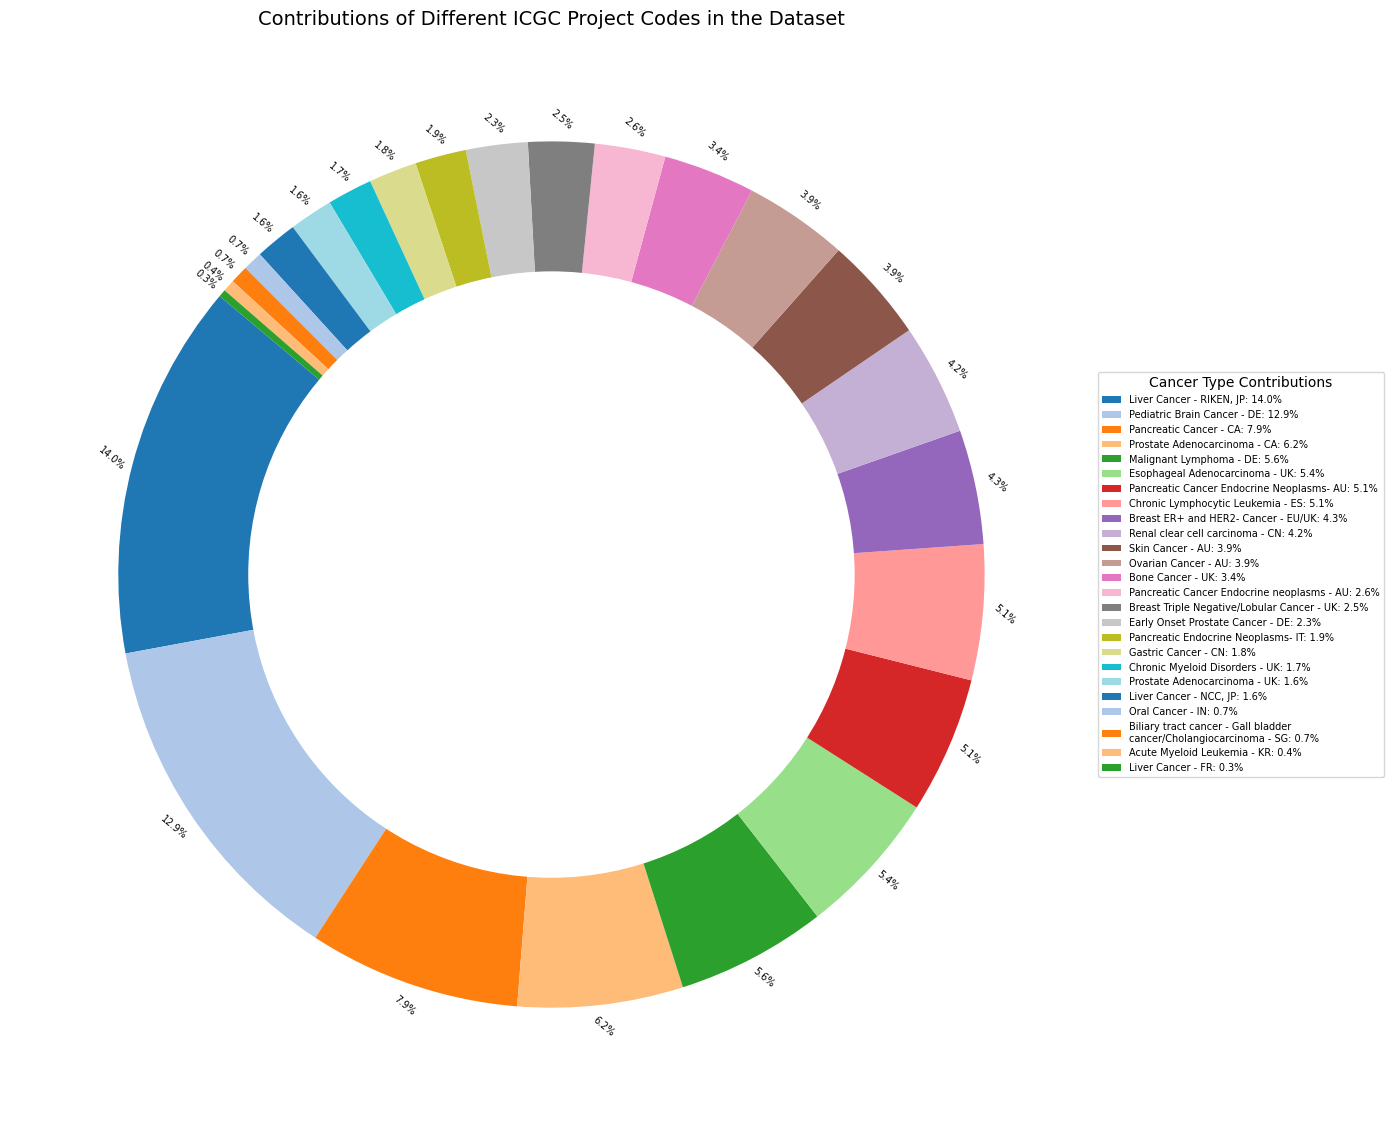

In [43]:
# Type + Region
project_counts = cgi_code_donor['dcc_project_code'].value_counts()
project_percentages = (project_counts / project_counts.sum()) * 100
unique_colors = sns.color_palette("tab20", n_colors=len(project_counts))

cancer_type_region_map = {
    'LIRI-JP': 'Liver Cancer - RIKEN, JP',
    'BRCA-UK': 'Breast Triple Negative/Lobular Cancer - UK',
    'EOPC-DE': 'Early Onset Prostate Cancer - DE',
    'ESAD-UK': 'Esophageal Adenocarcinoma - UK',
    'BRCA-EU': 'Breast ER+ and HER2- Cancer - EU/UK',
    'GACA-CN': 'Gastric Cancer - CN',
    'ORCA-IN': 'Oral Cancer - IN',
    'BTCA-SG': 'Biliary tract cancer - Gall bladder \ncancer/Cholangiocarcinoma - SG',
    'MELA-AU': 'Skin Cancer - AU',
    'MALY-DE': 'Malignant Lymphoma - DE',
    'PRAD-UK': 'Prostate Adenocarcinoma - UK',
    'PACA-CA': 'Pancreatic Cancer - CA',
    'LAML-KR': 'Acute Myeloid Leukemia - KR',
    'PACA-AU': 'Pancreatic Cancer Endocrine Neoplasms- AU',
    'PBCA-DE': 'Pediatric Brain Cancer - DE',
    'LICA-FR': 'Liver Cancer - FR',
    'LINC-JP': 'Liver Cancer - NCC, JP',
    'OV-AU': 'Ovarian Cancer - AU',
    'PAEN-AU': 'Pancreatic Cancer Endocrine neoplasms - AU',
    'PRAD-CA': 'Prostate Adenocarcinoma - CA',
    'RECA-EU': 'Renal clear cell carcinoma - CN',
    'CLLE-ES': 'Chronic Lymphocytic Leukemia - ES',
    'PAEN-IT': 'Pancreatic Endocrine Neoplasms- IT',
    'BOCA-UK': 'Bone Cancer - UK',
    'CMDI-UK': 'Chronic Myeloid Disorders - UK',
}

plt.figure(figsize=(14, 14))
wedges, texts, autotexts = plt.pie(
    project_counts, 
    labels=None,
    autopct='%1.1f%%', 
    startangle=140, 
    colors=unique_colors, 
    textprops={'fontsize': 7},
    pctdistance=1.05
)

for autotext in autotexts:
    autotext.set_rotation(-40)

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Create a legend with colors, cancer types, and percentages
mapped_cancer_types = [
    cancer_type_region_map.get(cancer_type, cancer_type)
    for cancer_type in project_counts.index
]

legend_labels = [
    f"{mapped_cancer_type}: {percentage:.1f}%" 
    for mapped_cancer_type, percentage in zip(mapped_cancer_types, project_percentages)
]

plt.legend(
    wedges, 
    legend_labels, 
    title="Cancer Type Contributions", 
    loc="center left", 
    bbox_to_anchor=(1, 0.5), 
    fontsize=7
)

# Title
plt.title('Contributions of Different ICGC Project Codes in the Dataset', fontsize=14)
plt.tight_layout()
plt.show()

In [44]:
cgi_code_donor_specific = cgi_code_donor
cgi_code_donor_specific['Type'] = cgi_code_donor_specific['dcc_project_code'].apply(lambda x: x.split('-')[0])
cgi_code_donor_specific['Region'] = cgi_code_donor_specific['dcc_project_code'].apply(lambda x: x.split('-')[1])

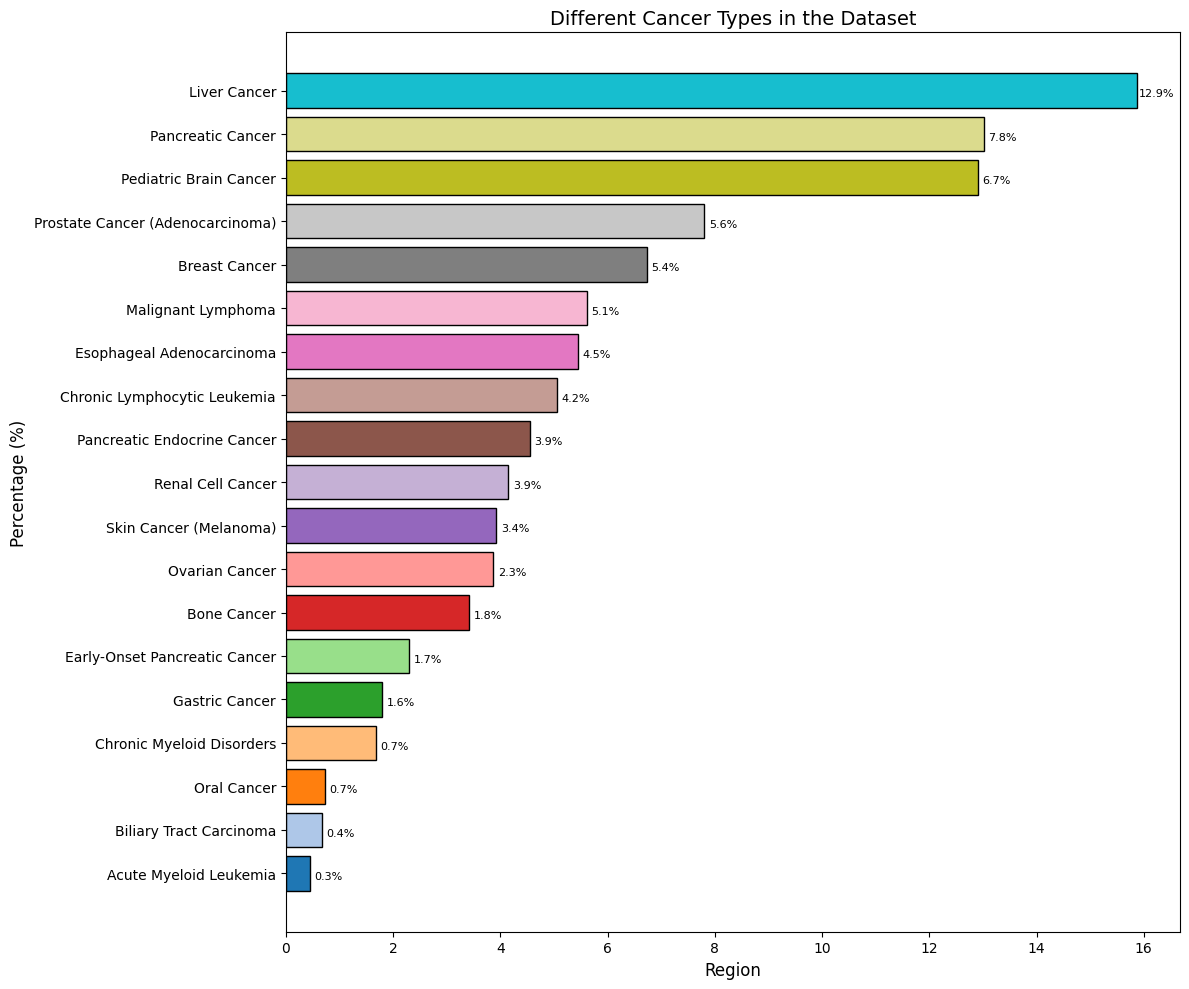

In [45]:
# Types of Cancer
type_counts = cgi_code_donor_specific['Type'].value_counts()
type_percentages = (type_counts / type_counts.sum()) * 100
unique_colors = sns.color_palette("tab20", n_colors=len(type_counts))

reversed_counts = type_counts.index[::-1]
reversed_percentages = type_percentages.iloc[::-1]

cancer_type_map = {
    'LIRI': 'Liver Cancer',
    'PACA': 'Pancreatic Cancer',
    'PBCA': 'Pediatric Brain Cancer',
    'PRAD': 'Prostate Cancer (Adenocarcinoma)',
    'BRCA': 'Breast Cancer',
    'MALY': 'Malignant Lymphoma',
    'ESAD': 'Esophageal Adenocarcinoma',
    'CLLE': 'Chronic Lymphocytic Leukemia',
    'PAEN': 'Pancreatic Endocrine Cancer',
    'RECA': 'Renal Cell Cancer',
    'MELA': 'Skin Cancer (Melanoma)',
    'OV': 'Ovarian Cancer',
    'BOCA': 'Bone Cancer',
    'EOPC': 'Early-Onset Pancreatic Cancer',
    'GACA': 'Gastric Cancer',
    'CMDI': 'Chronic Myeloid Disorders',
    'LINC': 'Liver Cancer',
    'ORCA': 'Oral Cancer',
    'BTCA': 'Biliary Tract Carcinoma',
    'LAML': 'Acute Myeloid Leukemia',
    'LICA': 'Liver Cancer'
}

# Map and Group
mapped_counts = [cancer_type_map.get(code, code) for code in reversed_counts]
data = pd.DataFrame({'Type': mapped_counts, 'Count': reversed_percentages.values})
grouped_data = data.groupby('Type', as_index=False).sum()
sorted_data = grouped_data.sort_values(by='Count', ascending=True)
sorted_counts = sorted_data['Type']
sorted_percentages = sorted_data['Count']

plt.figure(figsize=(12, 10))
bars = plt.barh(
    sorted_counts, 
    sorted_percentages, 
    color=unique_colors, 
    edgecolor='black'
)

for bar, percentage in zip(bars, reversed_percentages):
    plt.text(
        bar.get_width() + 0.35,
        bar.get_y() + bar.get_height() / 3,  
        f'{percentage:.1f}%', 
        ha='center', 
        fontsize=8
    )

plt.title('Different Cancer Types in the Dataset', fontsize=14)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()

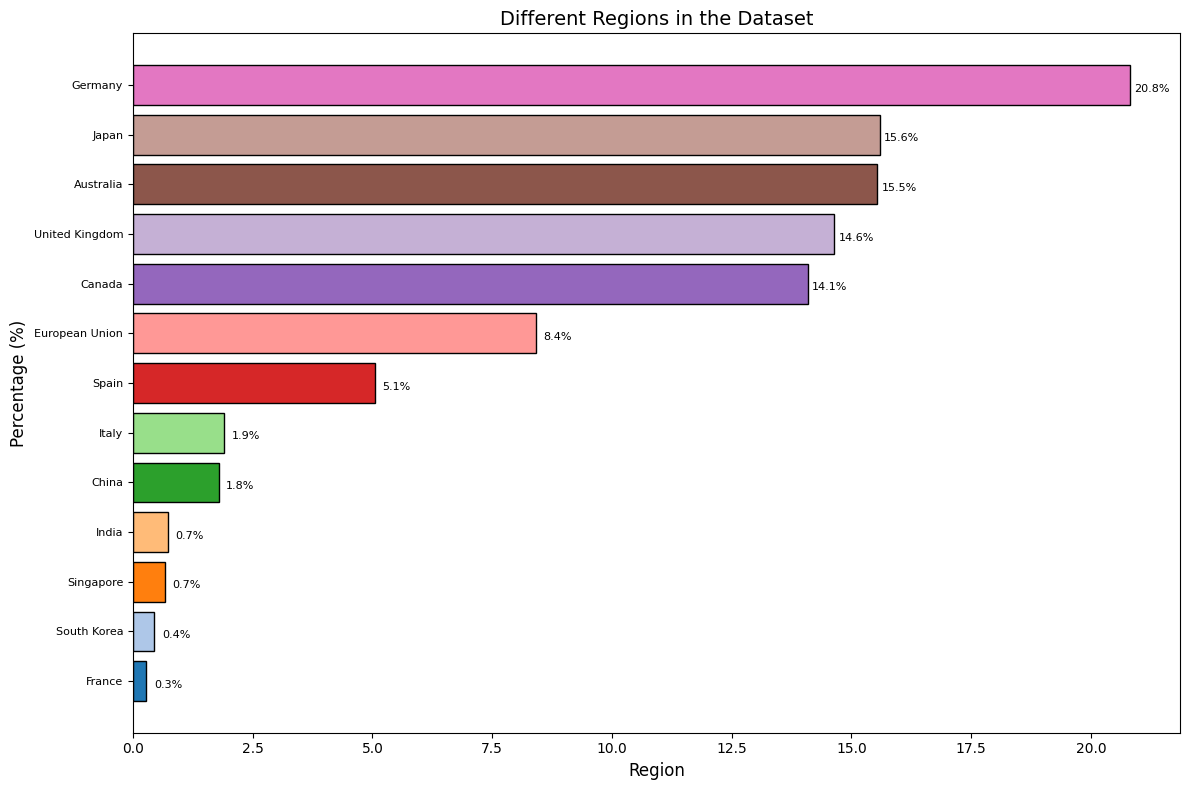

In [46]:
# Region
region_counts = cgi_code_donor_specific['Region'].value_counts()
region_percentages = (region_counts / region_counts.sum()) * 100
unique_colors = sns.color_palette("tab20", n_colors=len(region_counts))

reversed_regions = region_counts.index[::-1]
reversed_percentages = region_percentages.iloc[::-1]

region_map = {
    'DE': 'Germany',
    'JP': 'Japan',
    'AU': 'Australia',
    'UK': 'United Kingdom',
    'CA': 'Canada',
    'EU': 'European Union',
    'ES': 'Spain',
    'IT': 'Italy',
    'CN': 'China',
    'IN': 'India',
    'SG': 'Singapore',
    'KR': 'South Korea',
    'FR': 'France',
}

mapped_regions = [region_map.get(region, region) for region in reversed_regions]

plt.figure(figsize=(12, 8))
bars = plt.barh(
    mapped_regions, 
    reversed_percentages, 
    color=unique_colors[::1], 
    edgecolor='black'
)

for bar, percentage in zip(bars, reversed_percentages):
    plt.text(
        bar.get_width() + 0.45, 
        bar.get_y() + bar.get_height() / 3, 
        f'{percentage:.1f}%', 
        ha='center', 
        fontsize=8
    )

plt.title('Different Regions in the Dataset', fontsize=14)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

## Histology

In [47]:
histology_data = pd.read_csv('pcawg_specimen_histology_August2016_v9_donor', sep='\t')
histology_data['Sample'] = histology_data['icgc_specimen_id']
histology_data = histology_data.drop(columns=['icgc_specimen_id'])

In [48]:
cgi_with_histology = pd.merge(sample_level_df_new_cgi, histology_data, on='Sample')

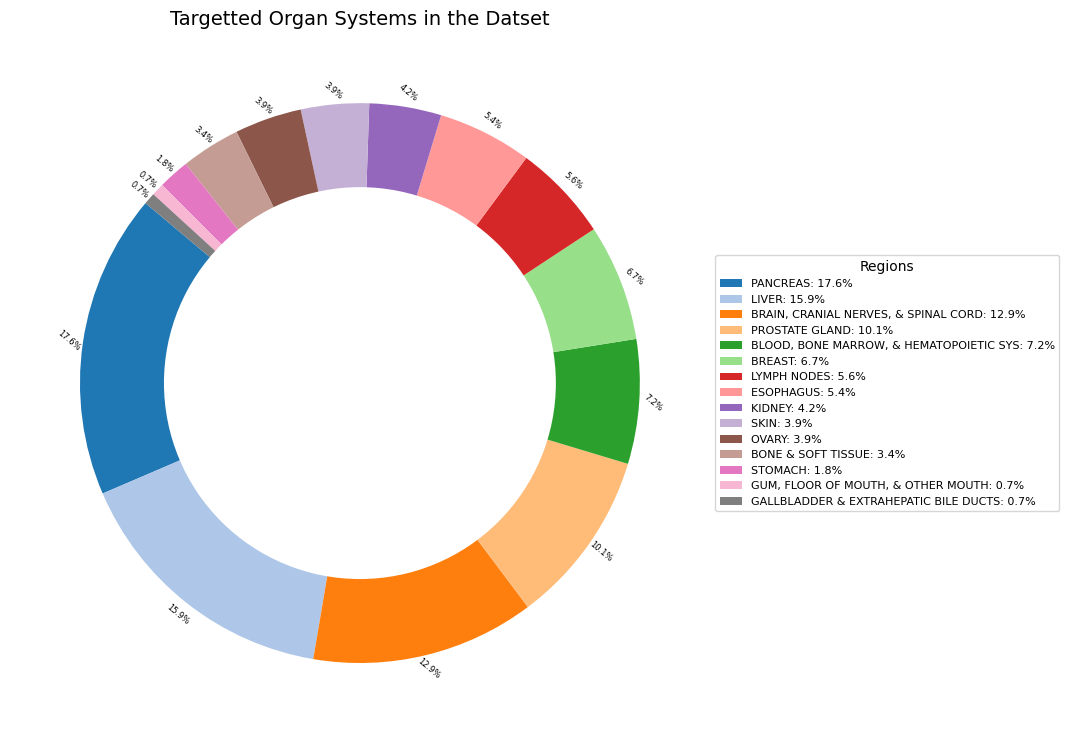

In [49]:
# Organ System
organ_counts = cgi_with_histology['organ_system'].value_counts()
organ_percentages = (organ_counts / organ_counts.sum()) * 100
unique_colors = sns.color_palette("tab20", n_colors=len(organ_counts))

plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(
    organ_counts, 
    labels=None,
    autopct='%1.1f%%', 
    startangle=140, 
    colors=unique_colors, 
    textprops={'fontsize': 6},
    pctdistance=1.05
)

for autotext in autotexts:
    autotext.set_rotation(-40)

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Create a legend with colors, organ systems, and percentages
legend_labels = [
    f"{organ}: {percentage:.1f}%" 
    for organ, percentage in zip(organ_counts.index, organ_percentages)
]

plt.legend(
    wedges, 
    legend_labels, 
    title="Regions", 
    loc="center left", 
    bbox_to_anchor=(1, 0.5), 
    fontsize=8
)

# Title
plt.title('Targetted Organ Systems in the Datset', fontsize=14)
plt.tight_layout()
plt.show()

In [50]:
# Histology Abbreviations & Tiers
cgi_with_histology_only = cgi_with_histology[['histology_abbreviation',
                                              'histology_tier1',
                                              'histology_tier2',
                                              'histology_tier3',
                                              'histology_tier4']]

hist_abb_counts = cgi_with_histology_only['histology_abbreviation'].value_counts()
hist_abb_percent =  (hist_abb_counts / hist_abb_counts.sum()) * 100
hist_abb_percent_new = hist_abb_percent.reset_index().rename(columns={"index": "histology_abbreviation", "count": "percent"})

###################
### Tiers 1 & 2 ###
###################
fig = px.sunburst(
    cgi_with_histology_only,
    path=[
        "histology_tier1",
        "histology_tier2"
    ],
    color='histology_tier1',
    color_discrete_sequence=px.colors.qualitative.Pastel,
    title='Histology Hierarchical Chart (Tiers 1 and 2)'
)

fig.update_layout(
    margin=dict(t=50, l=25, r=25, b=25)
)

# Display the chart
fig.show(renderer='iframe')

In [1386]:
######################
### Tiers 1, 2 & 3 ###
######################
fig = px.sunburst(
    cgi_with_histology_only,
    path=[
        "histology_tier1",
        "histology_tier2",
        "histology_tier3"
    ],
    color='histology_tier1',
    color_discrete_sequence=px.colors.qualitative.Pastel,
    title='Histology Hierarchical Chart (Tiers 1 - 3)'
)

fig.update_layout(
    margin=dict(t=50, l=25, r=25, b=25)
)

# Display the chart
fig.show(renderer='iframe')

In [1387]:
#################################
### Tiers 1, 2, 3 & 4 + abbr. ###
#################################
fig = px.sunburst(
    cgi_with_histology_only,
    path=[
        "histology_tier1",
        "histology_tier2",
        "histology_tier3",
        "histology_tier4",
        "histology_abbreviation"
    ],
    color='histology_tier1',
    color_discrete_sequence=px.colors.qualitative.Pastel,
    title='Histology Hierarchical Chart'
)

fig.update_layout(
    margin=dict(t=50, l=25, r=25, b=25)
)

# Display the chart
fig.show(renderer='iframe')

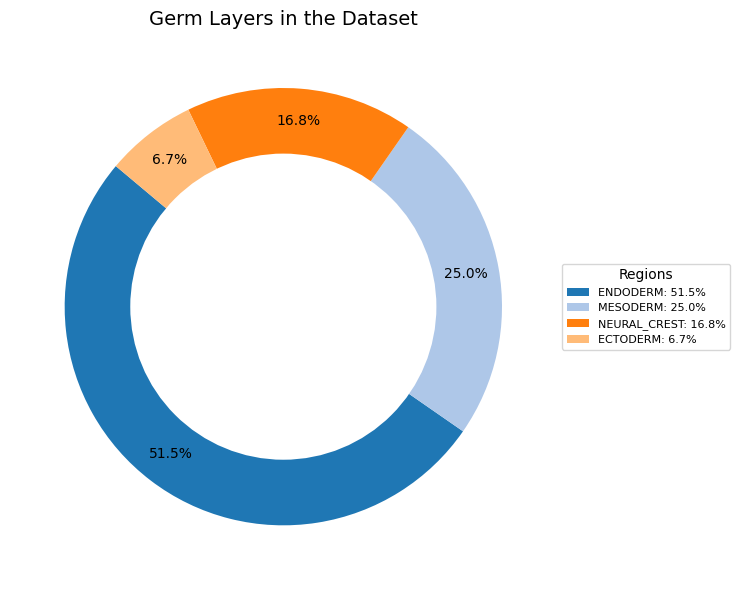

In [53]:
type_counts = cgi_with_histology['histology_tier1'].value_counts()
type_percentages = (type_counts / type_counts.sum()) * 100
unique_colors = sns.color_palette("tab20", n_colors=len(type_counts))

plt.figure(figsize=(10, 6))
wedges, texts, autotexts = plt.pie(
    type_counts, 
    labels=None,
    autopct='%1.1f%%', 
    startangle=140, 
    colors=unique_colors, 
    textprops={'fontsize': 10},
    pctdistance=0.85
)

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Create a legend with colors, organ systems, and percentages
legend_labels = [
    f"{type}: {percentage:.1f}%" 
    for type, percentage in zip(type_counts.index, type_percentages)
]

plt.legend(
    wedges, 
    legend_labels, 
    title="Regions", 
    loc="center left", 
    bbox_to_anchor=(1, 0.5), 
    fontsize=8
)

# Title
plt.title('Germ Layers in the Dataset', fontsize=14)
plt.tight_layout()
plt.show()

## Clincal Information

In [54]:
donor_clinical_info = pd.read_csv('pcawg_donor_clinical_August2016_v9', sep='\t')
donor_clinical_info['Sample'] = donor_clinical_info['icgc_donor_id']
donor_clinical_info = donor_clinical_info.drop(columns=['icgc_donor_id'])

In [55]:
cgi_clinical = pd.merge(sample_level_df_new_cgi, donor_clinical_info, on='Sample')

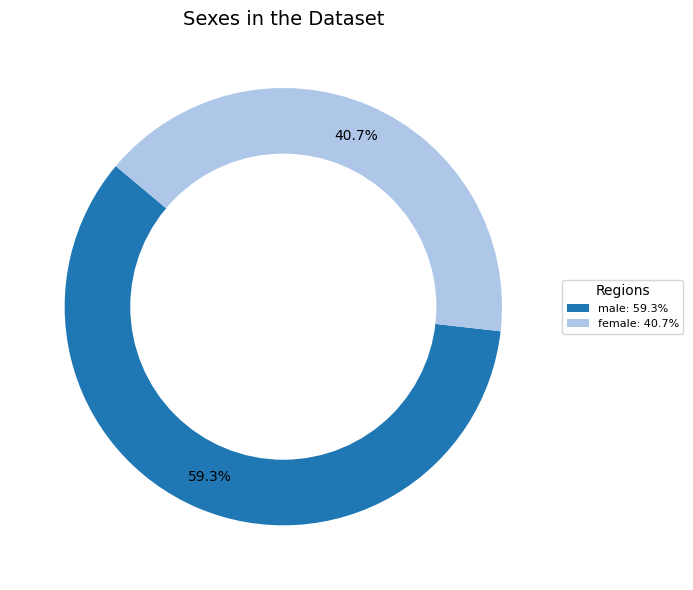

In [56]:
sex_counts = cgi_clinical['donor_sex'].value_counts()
sex_percentages = (sex_counts / sex_counts.sum()) * 100
unique_colors = sns.color_palette("tab20", n_colors=len(type_counts))

plt.figure(figsize=(10, 6))
wedges, texts, autotexts = plt.pie(
    sex_counts, 
    labels=None,
    autopct='%1.1f%%', 
    startangle=140, 
    colors=unique_colors, 
    textprops={'fontsize': 10},
    pctdistance=0.85
)

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Create a legend with colors, organ systems, and percentages
legend_labels = [
    f"{type}: {percentage:.1f}%" 
    for type, percentage in zip(sex_counts.index, sex_percentages)
]

plt.legend(
    wedges, 
    legend_labels, 
    title="Regions", 
    loc="center left", 
    bbox_to_anchor=(1, 0.5), 
    fontsize=8
)

# Title
plt.title('Sexes in the Dataset', fontsize=14)
plt.tight_layout()
plt.show()

## EDA Data Frame

In [57]:
important_clinical = cgi_clinical[['Sample', 'donor_sex']]
important_histology = cgi_with_histology[['Sample',
                                          'organ_system',
                                          'histology_abbreviation',
                                          'histology_tier1',
                                          'histology_tier2',
                                          'histology_tier3',
                                          'histology_tier4']]

important_type_region = cgi_code_donor_specific
important_type_region['dcc_project_code'] = important_type_region['dcc_project_code'].map(cancer_type_region_map)
important_type_region['Type'] = important_type_region['Type'].map(cancer_type_map)
important_type_region['Region'] = important_type_region['Region'].map(region_map)

In [58]:
eda_df_temp = pd.merge(important_clinical, important_histology, on='Sample')
eda_df = pd.merge(eda_df_temp, important_type_region, on='Sample')
print(eda_df)

       Sample donor_sex                             organ_system  \
0     DO46416    female                                    OVARY   
1     DO36062    female     BRAIN, CRANIAL NERVES, & SPINAL CORD   
2     DO45049      male                                    LIVER   
3     DO48578    female                                 PANCREAS   
4     DO46853    female                                   KIDNEY   
...       ...       ...                                      ...   
1777  DO47249    female                                   KIDNEY   
1778  DO51079      male                           PROSTATE GLAND   
1779  DO52704      male  BLOOD, BONE MARROW, & HEMATOPOIETIC SYS   
1780  DO23552    female                                    LIVER   
1781  DO51503    female                                 PANCREAS   

     histology_abbreviation histology_tier1 histology_tier2  \
0             Ovary-AdenoCA        MESODERM           Ovary   
1             CNS-PiloAstro    NEURAL_CREST             C

In [1388]:
grouped_eda_data = eda_df.groupby(['organ_system', 'Pathogenicity']).size().reset_index(name='count')
total_counts = grouped_eda_data.groupby('organ_system')['count'].sum().reset_index(name='total_count')
grouped_eda_data = grouped_eda_data.merge(total_counts, on='organ_system')

summary_data = grouped_eda_data.groupby('organ_system').apply(
    lambda x: '<br>'.join(f"{row['Pathogenicity']}: {row['count']}" for _, row in x.iterrows()), include_groups=False
).reset_index(name='summary')

grouped_eda_data = grouped_eda_data.merge(summary_data, on='organ_system')

fig = px.bar(
    grouped_eda_data,
    x='organ_system',
    y='count',
    color='Pathogenicity',
    title='Pathogenic TP53 Spread in Organs from Dataset',
    labels={'organ_system': 'Organ System', 'Pathogenicity': 'Pathogenicity Type'},
    hover_data={'summary': True}
)

for organ_system, total in zip(total_counts['organ_system'], total_counts['total_count']):
    fig.add_annotation(
        x=organ_system,
        y=total,
        text=str(total),
        showarrow=False,
        font=dict(size=12, color='black'),
        xanchor='center',
        yanchor='bottom'
    )


fig.update_layout(
    xaxis_title='Organ System',
    yaxis_title='Count',
    legend_title='Pathogenicity Type',
    barmode='stack',
    height=600,
    width=1000
)

fig.show(renderer='iframe')

# Feature Engineering

##  Signatures

In [725]:
pcawg_sigs = pd.read_csv('PCAWGmutsigs', sep='\t')
pcawg_sigs['Sample'] = pcawg_sigs['donor']
pcawg_sigs = pcawg_sigs.drop(columns=['donor'])

In [726]:
eda_df_new = eda_df[['Sample', 'Pathogenicity']]

In [727]:
pcawg_sigs_unique = pcawg_sigs.drop_duplicates(subset=['Sample'])
pathogenicity_sigs = pd.merge(eda_df_new, pcawg_sigs_unique, on='Sample', how='left')

In [728]:
# Convert to contributions (normalisation)
signature_columns = [col for col in pathogenicity_sigs.columns if col.startswith('Signature_')]
pathogenicity_sigs['row_sum'] = pathogenicity_sigs[signature_columns].sum(axis=1)
for col in signature_columns:
    pathogenicity_sigs[col] = pathogenicity_sigs[col] / pathogenicity_sigs['row_sum']

pathogenicity_sigs.drop(columns=['row_sum'], inplace=True)

In [729]:
print(pathogenicity_sigs)

       Sample                        Pathogenicity  Signature_1  Signature_2  \
0     DO46416  oncogenic (predicted and annotated)     0.035798     0.054810   
1     DO36062                              no tp53     0.163462     0.000000   
2     DO45049                              no tp53     0.000000     0.000000   
3     DO48578                              no tp53     0.079117     0.038638   
4     DO46853                              no tp53     0.036646     0.000000   
...       ...                                  ...          ...          ...   
1777  DO47249                              no tp53     0.061422     0.000000   
1778  DO51079                non-protein affecting     0.142309     0.013809   
1779  DO52704                              no tp53     0.058609     0.000000   
1780  DO23552                oncogenic (predicted)     0.000000     0.000000   
1781  DO51503                oncogenic (predicted)     0.212567     0.170393   

      Signature_3  Signature_4  Signatu

## Somatic Mutations

In [730]:
somatic_mut_df_temp = pd.read_csv('pcawg_consensus_1.6.161116.somatic_svs.xena.donor', sep='\t')
somatic_mut_df_temp['Sample'] = somatic_mut_df_temp['sample']
somatic_mut_df = somatic_mut_df_temp.drop(columns=['sample'])

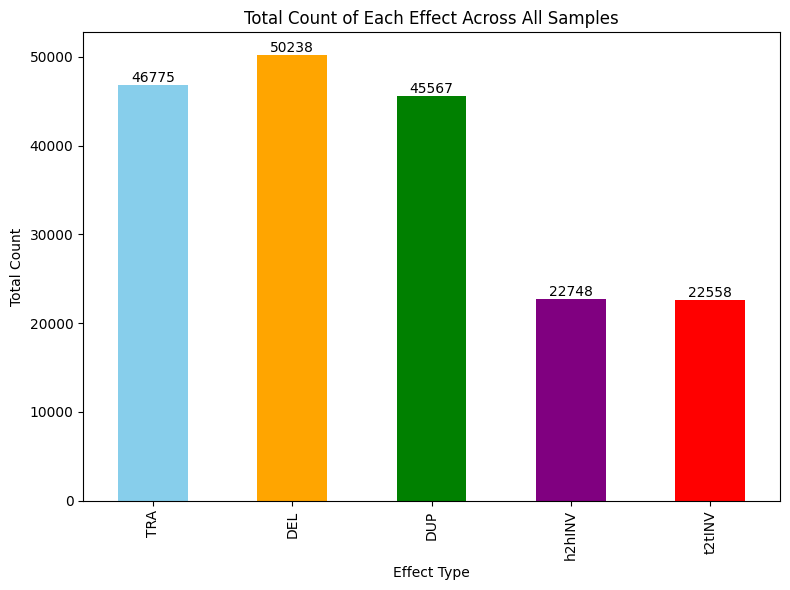

In [731]:
samples_in_eda = eda_df['Sample'].unique()
filtered_somatic_mut_df = somatic_mut_df[somatic_mut_df['Sample'].isin(samples_in_eda)]

all_effects = somatic_mut_df['effect'].unique()

empty_counts = pd.DataFrame(0, index=samples_in_eda, columns=all_effects).reset_index()
empty_counts.rename(columns={'index': 'Sample'}, inplace=True)
effect_counts = filtered_somatic_mut_df.groupby('Sample')['effect'].value_counts().unstack(fill_value=0).reset_index()

effect_counts = pd.merge(empty_counts, effect_counts, on='Sample', how='left')
effect_counts = effect_counts.fillna(0)
effect_counts.iloc[:, 1:] = effect_counts.iloc[:, 1:].astype(int)

effect_counts = effect_counts.astype({'Sample': 'str', **{col: 'int' for col in effect_counts.columns[1:]}})

# Rename and Drop
effect_counts['TRA'] = effect_counts['TRA_y']
effect_counts['DEL'] = effect_counts['DEL_y']
effect_counts['DUP'] = effect_counts['DUP_y']
effect_counts['h2hINV'] = effect_counts['h2hINV_y']
effect_counts['t2tINV'] = effect_counts['t2tINV_y']
effect_counts = effect_counts.drop(columns=['TRA_x', 
                                            'DEL_x', 
                                            'DUP_x', 
                                            't2tINV_x', 
                                            'h2hINV_x', 
                                            'TRA_y', 
                                            'DEL_y', 
                                            'DUP_y', 
                                            't2tINV_y', 
                                            'h2hINV_y'])

effect_counts_filtered = effect_counts

effect_totals = effect_counts_filtered.drop(columns="Sample").sum()

plt.figure(figsize=(8, 6))
ax = effect_totals.plot(kind='bar', color=['skyblue', 'orange', 'green', 'purple', 'red'])

# Add text labels on top of each bar
for i, value in enumerate(effect_totals):
    ax.text(i, value + 2, str(value), ha='center', va='bottom', fontsize=10)

plt.title("Total Count of Each Effect Across All Samples")
plt.xlabel("Effect Type")
plt.ylabel("Total Count")
plt.tight_layout()

plt.show()

## Copy Number Variants

In [753]:
path_sigs_with_effect_temp = pd.merge(pathogenicity_sigs, effect_counts_filtered, on='Sample')

In [754]:
def process_pathogenicity(df):
    pathogenicity_mapping = {
        "oncogenic (predicted and annotated)": "pathogenic",
        "oncogenic (predicted)": "pathogenic",
        "oncogenic (annotated)": "pathogenic",
        "no tp53": "not pathogenic",
        "non-oncogenic": "not pathogenic",
    }
    
    df["Pathogenicity"] = df["Pathogenicity"].map(pathogenicity_mapping)
    df = df.dropna(subset=["Pathogenicity"])

    return df
    
path_sigs_with_effect = process_pathogenicity(path_sigs_with_effect_temp)

In [755]:
print(path_sigs_with_effect)

       Sample   Pathogenicity  Signature_1  Signature_2  Signature_3  \
0     DO46416      pathogenic     0.035798     0.054810     0.138106   
1     DO36062  not pathogenic     0.163462     0.000000     0.000000   
2     DO45049  not pathogenic     0.000000     0.000000     0.000000   
3     DO48578  not pathogenic     0.079117     0.038638     0.000000   
4     DO46853  not pathogenic     0.036646     0.000000     0.000000   
...       ...             ...          ...          ...          ...   
1775  DO52159  not pathogenic     0.038596     0.000000     0.000000   
1777  DO47249  not pathogenic     0.061422     0.000000     0.000000   
1779  DO52704  not pathogenic     0.058609     0.000000     0.000000   
1780  DO23552      pathogenic     0.000000     0.000000     0.000000   
1781  DO51503      pathogenic     0.212567     0.170393     0.000000   

      Signature_4  Signature_5  Signature_6  Signature_7a  Signature_7b  ...  \
0             0.0     0.311439          0.0           0

In [756]:
cnv_temp1 = pd.read_csv('20170119_final_consensus_copynumber_donor', sep='\t')
cnv_temp = cnv_temp1[~cnv_temp1['chr'].isin(['X', 'Y'])].copy() # filter  out x abnd y
cnv_temp['length'] = cnv_temp['end'] - cnv_temp['start'] + 1
cnv_temp['is_loh'] = (cnv_temp['minor_cn'] == 0) & (cnv_temp['total_cn'] < 7)

In [757]:
cnv_temp['chr'] = cnv_temp['chr'].astype(int)
# cnv_temp['chr'] = cnv_temp['chr'] (if we include x and y)
grouped = cnv_temp.groupby(['sampleID', 'chr'])['length'].sum().reset_index()

# Pivot the table to create the desired format
summary_df = grouped.pivot_table(index='chr', columns='sampleID', values='length', fill_value=0)

summary_df.columns.name = None
summary_df.reset_index(inplace=True)
# summary_df = summary_df.sort_values(by='chr')

# Display the resulting DataFrame
print(summary_df)

    chr       DO1000       DO1001       DO1002       DO1003       DO1004  \
0     1  249149944.0  249240620.0  249250620.0  249240620.0  249250620.0   
1     2  242895075.0  242937752.0  242942299.0  242986318.0  242972253.0   
2     3  197782886.0  197945452.0  197784755.0  197560009.0  197959993.0   
3     4  190771061.0  190762981.0  191126776.0  191126776.0  190763068.0   
4     5  180892760.0  180693311.0  180685829.0  180650183.0  180670056.0   
5     6  170860120.0  170679552.0  170868146.0  170872973.0  170876455.0   
6     7  158781015.0  158781015.0  158781015.0  158758213.0  158731015.0   
7     8  146354021.0  145957285.0  146201626.0  146354021.0  146354021.0   
8     9  140225701.0  140225701.0  140214203.0  140945031.0  140225701.0   
9    10  135259912.0  135299798.0  135295499.0  135293491.0  135308274.0   
10   11  134431480.0  134431480.0  134431480.0  134381480.0  134234060.0   
11   12  133829395.0  133741788.0  133741788.0  133829395.0  133741788.0   
12   13  115

In [758]:
# length of all the samples genomes
val = (
    cnv_temp.groupby('sampleID')
    .apply(lambda x: x['length'].sum(), include_groups=False)
)

pd.set_option('display.max_rows', None)  # Show all rows
print(val)
pd.reset_option('display.max_rows')

# LOH calc
loh_by_sample = (
    cnv_temp.groupby('sampleID')
    .apply(lambda x: (x['is_loh'] * x['length']).sum() / x['length'].sum(), include_groups=False)
)

loh_by_sample = loh_by_sample.reset_index(name='loh_fraction')
loh_by_sample['Sample'] = loh_by_sample['sampleID']
loh_by_sample = loh_by_sample.drop(columns=['sampleID'])

print(loh_by_sample.sort_values(by='loh_fraction'))

sampleID
DO1000       2875357046
DO1001       2873214880
DO1002       2875526496
DO1003       2876834147
DO1004       2874082142
DO1005       2876436711
DO1006       2875013260
DO1007       2877005362
DO1008       2876360828
DO1009       2876345016
DO1010       2875156196
DO1011       2875662268
DO1012       2875779046
DO1013       2875781230
DO1014       2875705895
DO1015       2875024943
DO1016       2876360663
DO1017       2875863024
DO10172      2875530863
DO1018       2874302243
DO1020       2874359119
DO10324      2876836251
DO10486      2876782523
DO10631      2875498030
DO1076       2877075575
DO10806      2875275217
DO10807      2875546958
DO10809      2876067842
DO10811      2875994835
DO10813      2875172980
DO10815      2875226849
DO10817      2874174966
DO10819      2876332966
DO10821      2875357071
DO10823      2875917797
DO10825      2875408761
DO10829      2876197263
DO10831      2875727826
DO10833      2875928504
DO10835      2876443165
DO10837      2877933627
DO10839

In [798]:
path_sigs_loh_only = pd.merge(path_sigs_with_effect, loh_by_sample, on='Sample', how='left')

In [799]:
print(path_sigs_loh_only)

       Sample   Pathogenicity  Signature_1  Signature_2  Signature_3  \
0     DO46416      pathogenic     0.035798     0.054810     0.138106   
1     DO36062  not pathogenic     0.163462     0.000000     0.000000   
2     DO45049  not pathogenic     0.000000     0.000000     0.000000   
3     DO48578  not pathogenic     0.079117     0.038638     0.000000   
4     DO46853  not pathogenic     0.036646     0.000000     0.000000   
...       ...             ...          ...          ...          ...   
1430  DO52159  not pathogenic     0.038596     0.000000     0.000000   
1431  DO47249  not pathogenic     0.061422     0.000000     0.000000   
1432  DO52704  not pathogenic     0.058609     0.000000     0.000000   
1433  DO23552      pathogenic     0.000000     0.000000     0.000000   
1434  DO51503      pathogenic     0.212567     0.170393     0.000000   

      Signature_4  Signature_5  Signature_6  Signature_7a  Signature_7b  ...  \
0             0.0     0.311439          0.0           0

## Average size of CNV

In [800]:
average_length = cnv_temp.groupby('sampleID')['length'].mean()

average_length = average_length.reset_index(name='length')
average_length['Sample'] = average_length['sampleID']
average_length = average_length.drop(columns=['sampleID'])

average_length['avg_cnv_length'] = average_length['length']
average_length = average_length.drop(columns=['length'])

In [977]:
path_sigs_loh = pd.merge(path_sigs_loh_only, average_length, on='Sample', how='left')

In [978]:
print(path_sigs_loh)

       Sample   Pathogenicity  Signature_1  Signature_2  Signature_3  \
0     DO46416      pathogenic     0.035798     0.054810     0.138106   
1     DO36062  not pathogenic     0.163462     0.000000     0.000000   
2     DO45049  not pathogenic     0.000000     0.000000     0.000000   
3     DO48578  not pathogenic     0.079117     0.038638     0.000000   
4     DO46853  not pathogenic     0.036646     0.000000     0.000000   
...       ...             ...          ...          ...          ...   
1430  DO52159  not pathogenic     0.038596     0.000000     0.000000   
1431  DO47249  not pathogenic     0.061422     0.000000     0.000000   
1432  DO52704  not pathogenic     0.058609     0.000000     0.000000   
1433  DO23552      pathogenic     0.000000     0.000000     0.000000   
1434  DO51503      pathogenic     0.212567     0.170393     0.000000   

      Signature_4  Signature_5  Signature_6  Signature_7a  Signature_7b  ...  \
0             0.0     0.311439          0.0           0

## Trinucleotide Information (SNV)

In [979]:
def type_mutation(df):
    def format_type(row):
        start, end, ref, alt = row['start'], row['end'], row['reference'], row['alt']

        if start == end and len(ref) == 1 and len(alt) == 1:
            return 'SBS'
        elif len(ref) == 2 and len(alt) == 2:
            return 'DBS'
        elif (ref != '-' and alt == '-') or (ref == '-' and alt != '-'):
            return 'ID'
        elif len(ref) == len(alt):
            return 'SNV'
        return 'CN'

    df['Mutation_Type'] = df.apply(format_type, axis=1)
    return df

tri_nuc_samples = maf_data
tri_nuc_samples = type_mutation(tri_nuc_samples)

In [980]:
mutation_counts = tri_nuc_samples.groupby(["Sample", "Mutation_Type"]).size().unstack(fill_value=0)
mutation_proportions = mutation_counts.div(mutation_counts.sum(axis=1), axis=0)
tri_nuc_props = pd.concat([mutation_counts, mutation_proportions.add_suffix("_prop_small")], axis=1)

In [981]:
tri_nuc_props_filtered = tri_nuc_props[[col for col in tri_nuc_props.columns if not col.endswith('_prop_small')]]
tri_nuc_props_filtered = tri_nuc_props_filtered.reset_index()

In [982]:
path_sigs_tri_nuc = pd.merge(path_sigs_loh, tri_nuc_props_filtered, on='Sample', how='left')

## APOBEC Mutagenesis

In [983]:
apobec_df = pd.read_csv('MAF_Aug31_2016_sorted_A3A_A3B_comparePlus.donor', sep='\t')

In [984]:
apobec_df['Sample'] = apobec_df['Donor_ID']
apobec_df = apobec_df.drop(columns=['Donor_ID'])

In [985]:
path_sigs_apobec = pd.merge(path_sigs_tri_nuc, apobec_df, on='Sample', how='left')

In [986]:
print(path_sigs_apobec)

       Sample   Pathogenicity  Signature_1  Signature_2  Signature_3  \
0     DO46416      pathogenic     0.035798     0.054810     0.138106   
1     DO36062  not pathogenic     0.163462     0.000000     0.000000   
2     DO45049  not pathogenic     0.000000     0.000000     0.000000   
3     DO48578  not pathogenic     0.079117     0.038638     0.000000   
4     DO46853  not pathogenic     0.036646     0.000000     0.000000   
...       ...             ...          ...          ...          ...   
1430  DO52159  not pathogenic     0.038596     0.000000     0.000000   
1431  DO47249  not pathogenic     0.061422     0.000000     0.000000   
1432  DO52704  not pathogenic     0.058609     0.000000     0.000000   
1433  DO23552      pathogenic     0.000000     0.000000     0.000000   
1434  DO51503      pathogenic     0.212567     0.170393     0.000000   

      Signature_4  Signature_5  Signature_6  Signature_7a  Signature_7b  ...  \
0             0.0     0.311439          0.0           0

## Purity and Ploidy

In [987]:
ploidy_df = pd.read_csv('consensus.20170217.purity.ploidy_donor', sep='\t')
ploidy_df['Sample'] = ploidy_df['samplename']
ploidy_df = ploidy_df.drop(columns=['samplename'])

In [1088]:
# purity : estimated median purity (a low value represents high agreement across the purity callers)
# ploidy : calculated ploidy of the consensus profile
# purity_conf_mad : confidence in the purity call by means of taking the median absolute deviation across all available raw purity calls
# wgd_status : whole genome duplication status determined from the consensus copy number profile. A sample is whole genome 
#              doubled (wgd) or not (no_wgd)
# wgd_uncertain : a boolean denoting whether the whole genome duplication is uncertain. Interpret the copy number of these profiles 
#                 with caution
print(ploidy_df)

      purity  ploidy  purity_conf_mad wgd_status wgd_uncertain   Sample
0      0.885   3.355            0.039        wgd         FALSE  DO46416
1      0.774   2.001            0.022     no_wgd         FALSE  DO36062
2      0.800   2.428            0.011     no_wgd         FALSE  DO45049
3      0.837   1.831            0.030     no_wgd         FALSE  DO22145
4      0.920   1.637            0.003     no_wgd         FALSE  DO48578
...      ...     ...              ...        ...           ...      ...
2653   0.950   1.930            0.004     no_wgd         FALSE  DO52704
2654   0.859   1.718            0.007     no_wgd         FALSE  DO23552
2655   0.460   1.939            0.037     no_wgd         FALSE  DO38376
2656   0.600   2.593            0.011        wgd          TRUE    DO720
2657   0.853   1.794            0.006     no_wgd          TRUE  DO51503

[2658 rows x 6 columns]


In [1097]:
ploidy_important = ploidy_df[['Sample', 'purity', 'ploidy', 'wgd_status', 'wgd_uncertain']]

In [1098]:
path_sigs_ploidy = pd.merge(path_sigs_apobec, ploidy_important, on='Sample', how='left')

In [1099]:
path_sigs_final_df_temp = path_sigs_ploidy

In [1100]:
path_sigs_final_df = path_sigs_final_df_temp.drop(columns=['A3A_or_A3B']) # like 1.3k are NaN (only 110 are A3A and 80 A3B)

In [1101]:
print(path_sigs_final_df_temp)

       Sample   Pathogenicity  Signature_1  Signature_2  Signature_3  \
0     DO46416      pathogenic     0.035798     0.054810     0.138106   
1     DO36062  not pathogenic     0.163462     0.000000     0.000000   
2     DO45049  not pathogenic     0.000000     0.000000     0.000000   
3     DO48578  not pathogenic     0.079117     0.038638     0.000000   
4     DO46853  not pathogenic     0.036646     0.000000     0.000000   
...       ...             ...          ...          ...          ...   
1430  DO52159  not pathogenic     0.038596     0.000000     0.000000   
1431  DO47249  not pathogenic     0.061422     0.000000     0.000000   
1432  DO52704  not pathogenic     0.058609     0.000000     0.000000   
1433  DO23552      pathogenic     0.000000     0.000000     0.000000   
1434  DO51503      pathogenic     0.212567     0.170393     0.000000   

      Signature_4  Signature_5  Signature_6  Signature_7a  Signature_7b  ...  \
0             0.0     0.311439          0.0           0

## Gene Expression

In [1026]:
import requests
from io import StringIO

url = "https://pcawg-hub.s3.us-east-1.amazonaws.com/download/tophat_star_fpkm_uq.v2_aliquot_gl.donor.log"
response = requests.get(url)
response.raise_for_status()  # Raise an error for unsuccessful requests

data = StringIO(response.text)
gene_exp_df = pd.read_csv(data, delimiter="\t")

In [1086]:
print(gene_exp_df)

                   sample  DO45145  DO26512  DO6350  DO44090  DO45141  DO8264  \
0      ENSG00000000003.10   6.0230   4.2452 -7.3673   4.4784   4.6006  3.8918   
1       ENSG00000000005.5  -9.9658  -6.5955 -9.9658  -2.5579  -2.2989 -2.7778   
2       ENSG00000000419.8   4.5004   5.0261  4.3377   4.4732   4.9320  5.0431   
3       ENSG00000000457.9   1.2251   0.4099  0.8494   1.4436   1.9691  1.0066   
4      ENSG00000000460.12   0.5253   0.6832  1.7933   0.4356  -0.0627  0.1398   
...                   ...      ...      ...     ...      ...      ...     ...   
57815   ENSGR0000264819.1  -9.9658  -9.9658 -9.9658  -9.9658  -9.9658 -9.9658   
57816   ENSGR0000265350.1  -9.9658  -9.9658 -9.9658  -9.9658  -9.9658 -9.9658   
57817   ENSGR0000265658.1  -9.9658  -9.9658 -9.9658  -9.9658  -9.9658 -9.9658   
57818   ENSGR0000266731.1  -9.9658  -9.9658 -9.9658  -9.9658  -9.9658 -9.9658   
57819   ENSGR0000270726.1  -9.9658  -9.9658 -9.9658  -9.9658  -9.9658 -9.9658   

       DO45143  DO9042  DO1

In [1029]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load your DataFrame (assuming it's already in memory as `df`)
# Exclude the non-numeric column (e.g., the first column with gene IDs)
numeric_data = gene_exp_df.iloc[:, 1:]  # Keep only the numeric sample columns

# Normalize the data (standardize features to have mean=0 and variance=1)
scaler = StandardScaler()
normalized_data = scaler.fit_transform(numeric_data.T)  # Transpose to focus on samples

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(normalized_data)  # PCA on normalized data

pca_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance_ratio)

# Choose a reduced number of components (e.g., 10)
pca_reduced = pca_df.iloc[:, :10]  # Select the first 10 principal components

# Output the reduced PCA data
print(pca_reduced.head())


Explained variance ratio: [9.52672337e-02 5.08299025e-02 4.52430617e-02 ... 1.61351562e-04
 1.58223852e-04 4.64821173e-32]
          PC1        PC2        PC3        PC4        PC5        PC6  \
0  -27.072787 -45.277386 -15.488025   9.852666  84.862840  11.692575   
1  -46.459139   9.513530  10.823729  54.434699 -47.239417 -16.506018   
2  253.256477 -37.199970   3.949838  22.089207   7.142540 -38.636284   
3   18.531331  31.015215  14.088736  10.142163  -0.365429 -16.285992   
4    6.350948 -40.923796 -29.465093 -47.365788  66.631026  31.717823   

         PC7        PC8        PC9       PC10  
0  27.922620  31.668398 -21.824054  33.161596  
1  31.929030 -13.104084   0.983479  19.446886  
2 -15.294238  -8.768480  -5.881391 -25.192770  
3  33.428145 -11.444749  43.805847 -18.199388  
4  47.605597  24.169805   9.450394   7.179530  


## Gene Effect Counts in Sample

In [1424]:
gene_effect_df = tester_maf

In [1425]:
gene_effect_counts = gene_effect_df.groupby(["Sample", "effect"]).size().unstack(fill_value=0)
gene_effect_counts_filtered_temp = gene_effect_counts.reset_index()
gene_effect_counts_filtered = gene_effect_counts_filtered_temp

In [1426]:
path_sigs_effects = pd.merge(path_sigs_final_df_temp, gene_effect_counts_filtered, on='Sample', how='left')

In [1427]:
print(path_sigs_effects)

       Sample   Pathogenicity  Signature_1  Signature_2  Signature_3  \
0     DO46416      pathogenic     0.035798     0.054810     0.138106   
1     DO36062  not pathogenic     0.163462     0.000000     0.000000   
2     DO45049  not pathogenic     0.000000     0.000000     0.000000   
3     DO48578  not pathogenic     0.079117     0.038638     0.000000   
4     DO46853  not pathogenic     0.036646     0.000000     0.000000   
...       ...             ...          ...          ...          ...   
1430  DO52159  not pathogenic     0.038596     0.000000     0.000000   
1431  DO47249  not pathogenic     0.061422     0.000000     0.000000   
1432  DO52704  not pathogenic     0.058609     0.000000     0.000000   
1433  DO23552      pathogenic     0.000000     0.000000     0.000000   
1434  DO51503      pathogenic     0.212567     0.170393     0.000000   

      Signature_4  Signature_5  Signature_6  Signature_7a  Signature_7b  ...  \
0             0.0     0.311439          0.0           0

In [1450]:
path_sigs_final_df = path_sigs_effects.drop(columns=['A3A_or_A3B'])

# Machine Learning Algorithms

NOTE: Starting with 1435 samples (filtered out for unknown pathogenicity)\

The global seems to be ideal (with the missense and nonsense)

Not ideal for pancreatic

## Global

In [1451]:
path_sigs_final_df = path_sigs_final_df.copy()

label = LabelEncoder()
path_sigs_final_df['Pathogenicity_Encoded'] = label.fit_transform(path_sigs_final_df['Pathogenicity'])
# path_sigs_final_df['A3A_or_A3B'] = label.fit_transform(path_sigs_final_df['A3A_or_A3B'])
path_sigs_final_df['wgd_status'] = label.fit_transform(path_sigs_final_df['wgd_status'])
path_sigs_final_df['wgd_uncertain'] = label.fit_transform(path_sigs_final_df['wgd_uncertain'])

In [1449]:
X = path_sigs_final_df.drop(columns=['Sample', 'Pathogenicity', 'Pathogenicity_Encoded'])
y = path_sigs_final_df['Pathogenicity_Encoded']
feature_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

rfc = RandomForestClassifier(random_state=42, class_weight='balanced')

# Optimal
# rfc = RandomForestClassifier(random_state=42, 
#                              bootstrap=True, 
#                              max_depth=20, 
#                              min_samples_leaf=1, 
#                              min_samples_split=5,
#                              n_estimators=200,
#                              class_weight='balanced'
#                             )

rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.8697674418604651

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       175
           1       0.75      0.45      0.56        40

    accuracy                           0.87       215
   macro avg       0.82      0.71      0.74       215
weighted avg       0.86      0.87      0.86       215



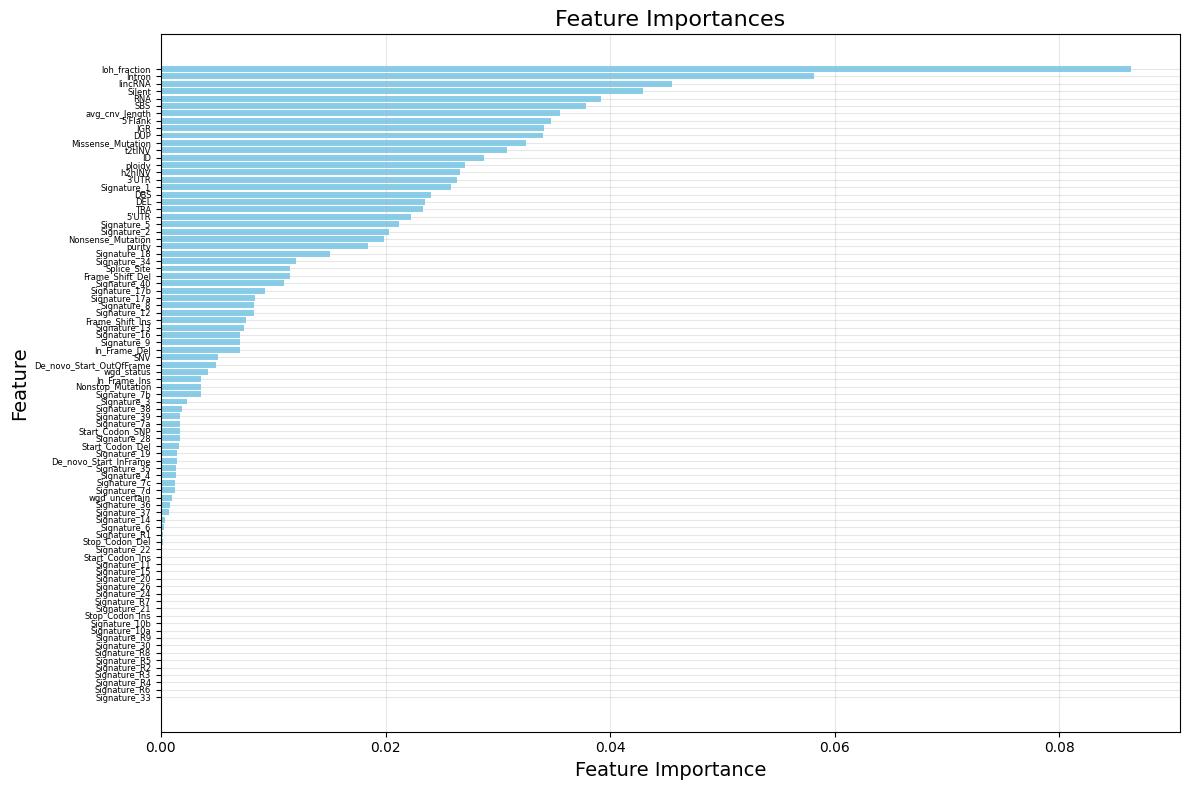

In [1431]:
feature_importances = rfc.feature_importances_

# Create a DataFrame for better visualization
importance_df_global = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot all features
plt.figure(figsize=(12, 8))
plt.barh(importance_df_global['Feature'], importance_df_global['Importance'], color='skyblue')
plt.gca().invert_yaxis()

# Add labels and title
plt.xlabel('Feature Importance', fontsize=14)
plt.yticks(fontsize=6)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importances', fontsize=16)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

In [1432]:
# Get only the important features
important_features_global = importance_df_global[importance_df_global['Importance'] > 0]
important_feature_names_global = important_features_global['Feature'].tolist()

X_train_filtered = X_train[important_feature_names_global]
X_test_filtered = X_test[important_feature_names_global]
X_val_filtered = X_val[important_feature_names_global]

In [1297]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report

param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_features': ['sqrt', 'log2', None]
}

# Instantiate the model
rfc = RandomForestClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, 
                           scoring='accuracy', cv=2, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_filtered, y_train)

# Retrieve the best parameters and the best estimator
best_params = grid_search.best_params_
best_rfc = grid_search.best_estimator_
best_score = grid_search.best_score_

# Evaluate the best model on the test set
y_pred = best_rfc.predict(X_test_filtered)

Fitting 2 folds for each of 2160 candidates, totalling 4320 fits
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   1.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; 

In [1298]:
print("\nBest Hyperparameters:\n", best_params)
print("\nBest Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("Best Cross-Validation Accuracy:", best_score)
print(best_rfc)


Best Hyperparameters:
 {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Best Model Accuracy: 0.8697674418604651

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92       175
           1       0.73      0.47      0.58        40

    accuracy                           0.87       215
   macro avg       0.81      0.72      0.75       215
weighted avg       0.86      0.87      0.86       215

Best Cross-Validation Accuracy: 0.8625498007968128
RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       random_state=42)


In [1299]:
from scipy.stats import randint

param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(0, 40),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_features': ['sqrt', 'log2', None]
}

# Instantiate the model
rfc = RandomForestClassifier(random_state=42)

# Perform RandomizedSearchCV with 2 folds
random_search = RandomizedSearchCV(estimator=rfc, 
                                   param_distributions=param_distributions, 
                                   n_iter=100,
                                   scoring='accuracy', 
                                   cv=7, #cross val 5?
                                   n_jobs=-1,
                                   verbose=2, 
                                   random_state=42)

# Fit the random search to the data
random_search.fit(X_train_filtered, y_train)

# Retrieve the best parameters and the best estimator
best_params = random_search.best_params_
best_rfc = random_search.best_estimator_
best_score = random_search.best_score_

# Evaluate the best model on the test set
y_pred = best_rfc.predict(X_test_filtered)

Fitting 7 folds for each of 100 candidates, totalling 700 fits

[CV] END bootstrap=False, class_weight=balanced_subsample, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.8s
[CV] END bootstrap=False, class_weight=balanced_subsample, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.8s
[CV] END bootstrap=False, class_weight=balanced_subsample, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.3s
[CV] END bootstrap=False, class_weight=balanced_subsample, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.2s
[CV] END bootstrap=False, class_weight=balanced_subsample, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  11.1s
[CV] END bootstrap=False, class_weight=balanced_subsample, max_depth=20, max_feature

/Users/asanghvi/Desktop/ML/ML_practice/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning:


14 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/asanghvi/Desktop/ML/ML_practice/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/asanghvi/Desktop/ML/ML_practice/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/asanghvi/Desktop/ML/ML_practice/.venv/lib/python3.12/site-packages/sklearn/b

In [1300]:
# Print results
print("\nBest Hyperparameters:\n", best_params)
print("\nBest Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("Best Cross-Validation Accuracy:", best_score)
print(best_rfc)


Best Hyperparameters:
 {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_depth': 36, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 194}

Best Model Accuracy: 0.8744186046511628

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.93       175
           1       0.72      0.53      0.61        40

    accuracy                           0.87       215
   macro avg       0.81      0.74      0.77       215
weighted avg       0.87      0.87      0.87       215

Best Cross-Validation Accuracy: 0.8705183705183704
RandomForestClassifier(class_weight='balanced_subsample', max_depth=36,
                       min_samples_split=6, n_estimators=194, random_state=42)


In [1439]:
# Grid optimsaiton
kf = KFold(n_splits=15, shuffle=True, random_state=42)

accuracies = []
classification_reports = []

X = path_sigs_final_df.drop(columns=['Sample', 'Pathogenicity', 'Pathogenicity_Encoded'])
y = path_sigs_final_df['Pathogenicity_Encoded']

# Filter it here
X = X[important_feature_names_global]

# Perform KFold Cross-Validation
fold = 1
for train_index, test_index in kf.split(X):
    print(f"\nFold {fold}")
    fold += 1

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Further split the test set into validation and test sets
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

    # Keep only the important features
    # X_train_filtered = X_train[important_feature_names_global]
    # X_test_filtered = X_test[important_feature_names_global]
    # X_val_filtered = X_val[important_feature_names_global]

    X_train_filtered = X_train
    X_test_filtered = X_test
    X_val_filtered = X_val
    
    rfc = RandomForestClassifier(random_state=42, 
                                 bootstrap=True, 
                                 max_depth=6, 
                                 min_samples_leaf=1, 
                                 min_samples_split=2,
                                 n_estimators=100,
                                 class_weight='balanced_subsample',
                                 max_features='sqrt'
                                )
    rfc.fit(X_train_filtered, y_train)
    
    # Predict and evaluate
    y_pred = rfc.predict(X_test_filtered)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
    
    # Store results
    accuracies.append(accuracy)
    classification_reports.append(report)
    
    # Print results for the current fold
    print(f"Accuracy: {accuracy}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

print("\nOverall Performance:")
print(f"Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")


Fold 1
Accuracy: 0.8125

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.79      0.87        38
           1       0.53      0.90      0.67        10

    accuracy                           0.81        48
   macro avg       0.75      0.84      0.77        48
weighted avg       0.88      0.81      0.83        48


Fold 2
Accuracy: 0.8333333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90        41
           1       0.44      0.57      0.50         7

    accuracy                           0.83        48
   macro avg       0.68      0.72      0.70        48
weighted avg       0.85      0.83      0.84        48


Fold 3
Accuracy: 0.75

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.75      0.83        40
           1       0.38      0.75      0.50         8

    accuracy          

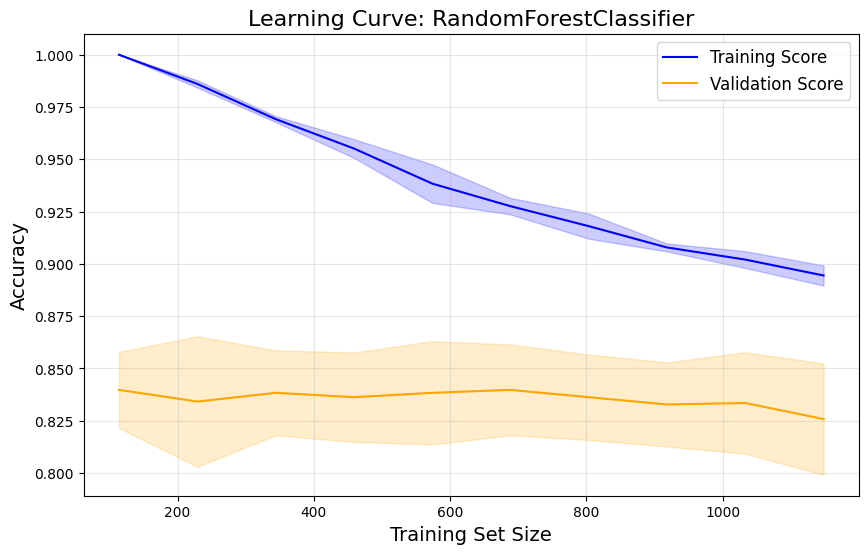

In [1440]:
# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=rfc,
    X=X,
    y=y,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# mean and sd
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.plot(train_sizes, val_mean, label='Validation Score', color='orange')

# Fill between mean ± std
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')

# Labels, legend, and title
plt.title('Learning Curve: RandomForestClassifier', fontsize=16)
plt.xlabel('Training Set Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

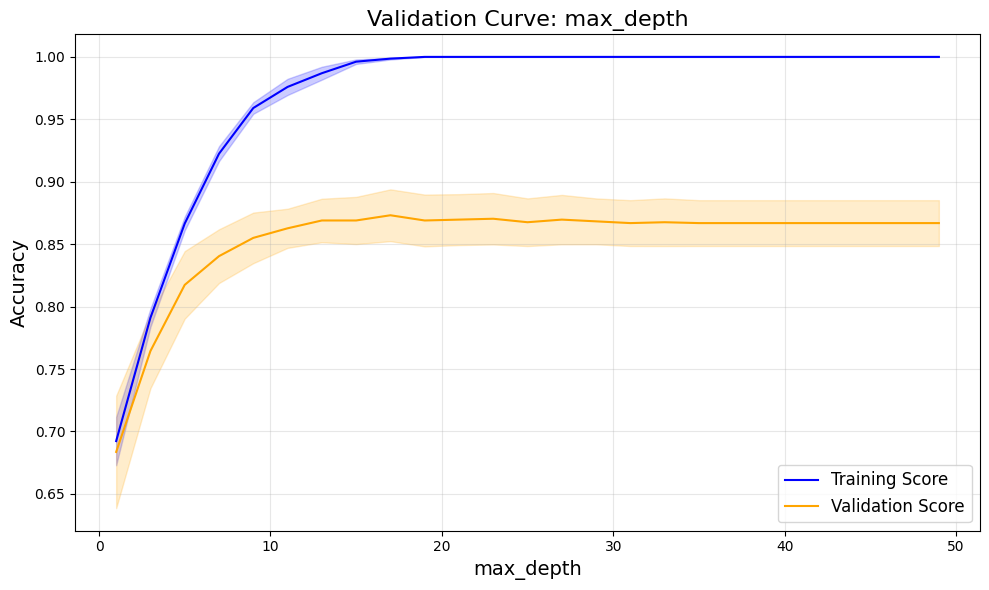

In [1441]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve

# Define the parameter and its range for the validation curve
param_name = "max_depth"
param_range = np.arange(1, 51, 2)

# Calculate training and validation scores
train_scores, val_scores = validation_curve(
    estimator=rfc,
    X=X,
    y=y,
    param_name=param_name,
    param_range=param_range,
    cv=5,  # 5-fold cross-validation
    scoring="accuracy",
    n_jobs=-1
)

# Calculate mean and standard deviation for each value of the parameter
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training Score", color="blue")
plt.plot(param_range, val_mean, label="Validation Score", color="orange")

# Add shaded areas for ± std
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, color="orange", alpha=0.2)

# Add labels and legend
plt.title(f"Validation Curve: {param_name}", fontsize=16)
plt.xlabel(param_name, fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

In [1442]:
# random search optimsation
kf = KFold(n_splits=15, shuffle=True, random_state=42)

accuracies = []
classification_reports = []

X = path_sigs_final_df.drop(columns=['Sample', 'Pathogenicity', 'Pathogenicity_Encoded'])
y = path_sigs_final_df['Pathogenicity_Encoded']

# Filter it here instead of later
X = X[important_feature_names_global]

# Perform KFold Cross-Validation
fold = 1
for train_index, test_index in kf.split(X):
    print(f"\nFold {fold}")
    fold += 1

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Further split the test set into validation and test sets
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

    # Keep only the important features
    # X_train_filtered = X_train[important_feature_names_global]
    # X_test_filtered = X_test[important_feature_names_global]
    # X_val_filtered = X_val[important_feature_names_global]

    X_train_filtered = X_train
    X_test_filtered = X_test
    X_val_filtered = X_val
    
    rfc = RandomForestClassifier(random_state=42, 
                                 bootstrap=True, 
                                 max_depth=8,
                                 min_samples_leaf=1, 
                                 min_samples_split=6,
                                 n_estimators=194,
                                 class_weight='balanced_subsample',
                                 max_features='sqrt'
                                )
    rfc.fit(X_train_filtered, y_train)
    
    # Predict and evaluate
    y_pred = rfc.predict(X_test_filtered)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
    
    # Store results
    accuracies.append(accuracy)
    classification_reports.append(report)
    
    # Print results for the current fold
    print(f"Accuracy: {accuracy}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

print("\nOverall Performance:")
print(f"Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")


Fold 1
Accuracy: 0.8333333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.84      0.89        38
           1       0.57      0.80      0.67        10

    accuracy                           0.83        48
   macro avg       0.76      0.82      0.78        48
weighted avg       0.86      0.83      0.84        48


Fold 2
Accuracy: 0.875

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93        41
           1       0.57      0.57      0.57         7

    accuracy                           0.88        48
   macro avg       0.75      0.75      0.75        48
weighted avg       0.88      0.88      0.88        48


Fold 3
Accuracy: 0.7708333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.80      0.85        40
           1       0.38      0.62      0.48         8

    accur

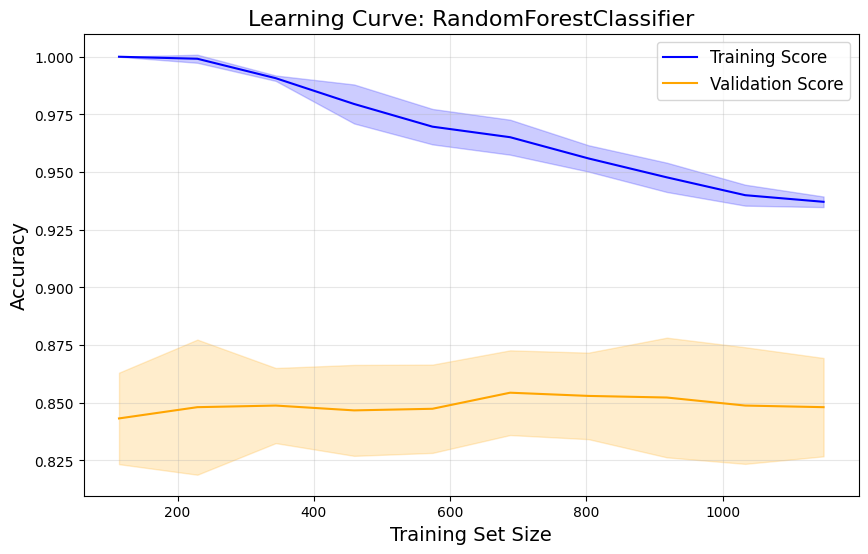

In [1443]:
# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=rfc,
    X=X,
    y=y,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# mean and sd
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.plot(train_sizes, val_mean, label='Validation Score', color='orange')

# Fill between mean ± std
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')

# Labels, legend, and title
plt.title('Learning Curve: RandomForestClassifier', fontsize=16)
plt.xlabel('Training Set Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

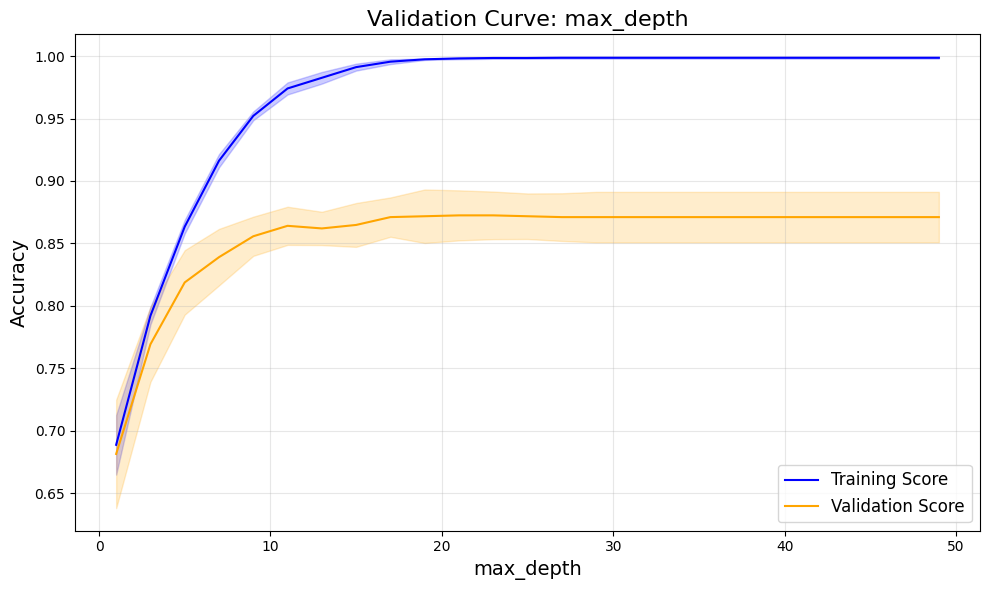

In [1444]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve

# Define the parameter and its range for the validation curve
param_name = "max_depth"
param_range = np.arange(1, 51, 2)

# Calculate training and validation scores
train_scores, val_scores = validation_curve(
    estimator=rfc,
    X=X,
    y=y,
    param_name=param_name,
    param_range=param_range,
    cv=5,  # 5-fold cross-validation
    scoring="accuracy",
    n_jobs=-1
)

# Calculate mean and standard deviation for each value of the parameter
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training Score", color="blue")
plt.plot(param_range, val_mean, label="Validation Score", color="orange")

# Add shaded areas for ± std
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, color="orange", alpha=0.2)

# Add labels and legend
plt.title(f"Validation Curve: {param_name}", fontsize=16)
plt.xlabel(param_name, fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

## Pancreatic

In [1452]:
pancreatic_df = eda_df[eda_df['organ_system'] == 'PANCREAS'][['Sample']]
list_panc_samples = pancreatic_df['Sample'].unique()

In [1453]:
filtered_path_sigs_loh = path_sigs_final_df[path_sigs_final_df['Sample'].isin(list_panc_samples)]

In [1454]:
print(filtered_path_sigs_loh) #216 samples

       Sample   Pathogenicity  Signature_1  Signature_2  Signature_3  \
3     DO48578  not pathogenic     0.079117     0.038638     0.000000   
12    DO51493      pathogenic     0.059567     0.047320     0.811022   
13    DO46785  not pathogenic     0.000000     0.000000     0.000000   
20    DO46781  not pathogenic     0.038961     0.021978     0.000000   
24    DO34432      pathogenic     0.212214     0.049618     0.000000   
...       ...             ...          ...          ...          ...   
1327  DO35132      pathogenic     0.254270     0.051563     0.000000   
1333  DO48557  not pathogenic     0.096658     0.024165     0.000000   
1425  DO35406      pathogenic     0.227540     0.011545     0.000000   
1430  DO52159  not pathogenic     0.038596     0.000000     0.000000   
1434  DO51503      pathogenic     0.212567     0.170393     0.000000   

      Signature_4  Signature_5  Signature_6  Signature_7a  Signature_7b  ...  \
3             0.0     0.807268          0.0           0

In [1455]:
X = filtered_path_sigs_loh.drop(columns=['Sample', 'Pathogenicity', 'Pathogenicity_Encoded'])
y = filtered_path_sigs_loh['Pathogenicity_Encoded']
feature_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

rfc = RandomForestClassifier(random_state=42, class_weight='balanced')
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.84375

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87        20
           1       0.77      0.83      0.80        12

    accuracy                           0.84        32
   macro avg       0.83      0.84      0.84        32
weighted avg       0.85      0.84      0.84        32



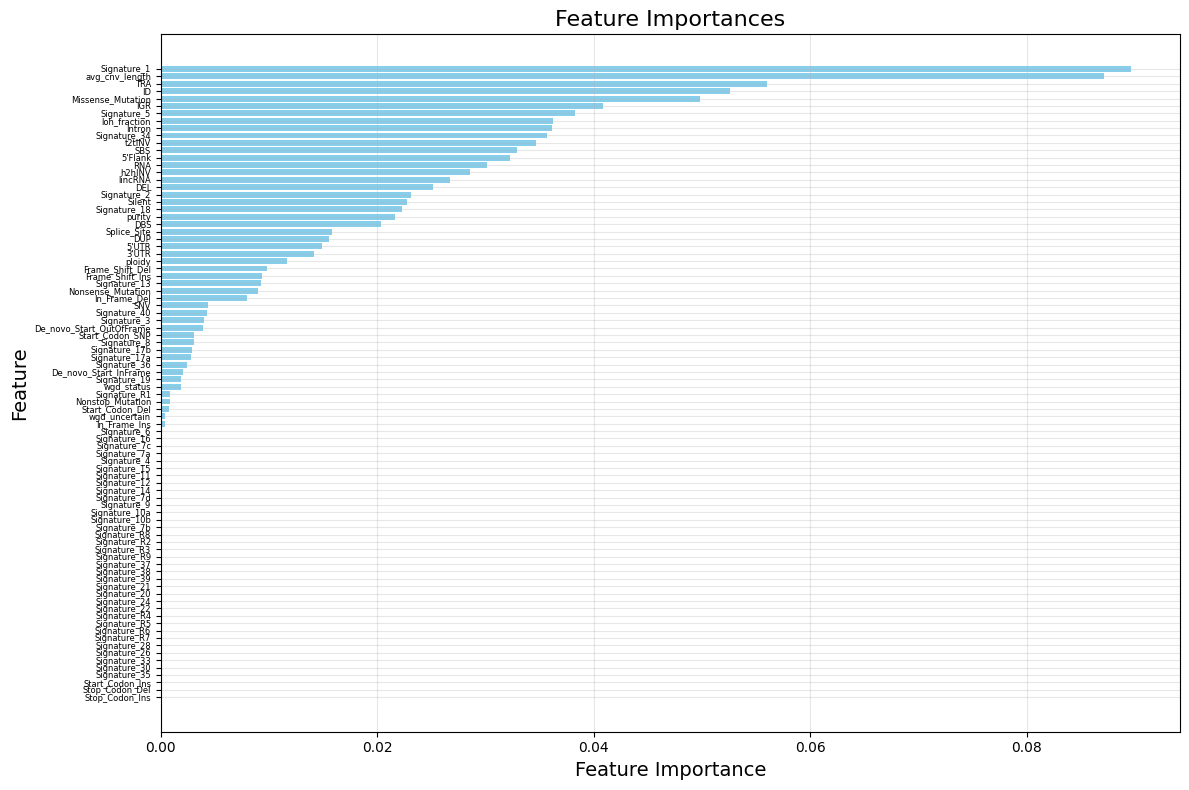

In [1456]:
feature_importances = rfc.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot all features
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()

# Add labels and title
plt.xlabel('Feature Importance', fontsize=14)
plt.yticks(fontsize=6)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importances', fontsize=16)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

In [1457]:
# Get only the important features
importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
important_features = importance_df[importance_df['Importance'] > 0]
important_feature_names = important_features['Feature'].tolist()

X_train_filtered = X_train[important_feature_names]
X_test_filtered = X_test[important_feature_names]
X_val_filtered = X_val[important_feature_names]

In [1332]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report

param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_features': ['sqrt', 'log2', None]
}

# Instantiate the model
rfc = RandomForestClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, 
                           scoring='accuracy', cv=2, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_filtered, y_train)

# Retrieve the best parameters and the best estimator
best_params = grid_search.best_params_
best_rfc = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_rfc.predict(X_test_filtered)

Fitting 2 folds for each of 1728 candidates, totalling 3456 fits
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.8s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400

In [1333]:
print("\nBest Hyperparameters:\n", best_params)
print("\nBest Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))


Best Hyperparameters:
 {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Best Model Accuracy: 0.8125

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86        20
           1       0.80      0.67      0.73        12

    accuracy                           0.81        32
   macro avg       0.81      0.78      0.79        32
weighted avg       0.81      0.81      0.81        32



In [1336]:
from scipy.stats import randint

param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(0, 20),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_features': ['sqrt', 'log2', None]
}

# Instantiate the model
rfc = RandomForestClassifier(random_state=42)

# Perform RandomizedSearchCV with 2 folds
random_search = RandomizedSearchCV(estimator=rfc, 
                                   param_distributions=param_distributions, 
                                   n_iter=100,
                                   scoring='accuracy', 
                                   cv=7, #cross val 5?
                                   n_jobs=-1,
                                   verbose=2, 
                                   random_state=42)

# Fit the random search to the data
random_search.fit(X_train_filtered, y_train)

# Retrieve the best parameters and the best estimator
best_params = random_search.best_params_
best_rfc = random_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_rfc.predict(X_test_filtered)

Fitting 7 folds for each of 100 candidates, totalling 700 fits

[CV] END bootstrap=False, class_weight=balanced_subsample, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, class_weight=balanced_subsample, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   2.0s
[CV] END bootstrap=False, class_weight=balanced_subsample, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, class_weight=balanced_subsample, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, class_weight=balanced_subsample, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, class_weight=balanced_subsample, max_depth=20, max_featu

/Users/asanghvi/Desktop/ML/ML_practice/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning:


56 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
56 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/asanghvi/Desktop/ML/ML_practice/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/asanghvi/Desktop/ML/ML_practice/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/asanghvi/Desktop/ML/ML_practice/.venv/lib/python3.12/site-packages/sklearn/b

In [1337]:
# Print results
print("\nBest Hyperparameters:\n", best_params)
print("\nBest Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))


Best Hyperparameters:
 {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 497}

Best Model Accuracy: 0.8125

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84        20
           1       0.71      0.83      0.77        12

    accuracy                           0.81        32
   macro avg       0.80      0.82      0.81        32
weighted avg       0.82      0.81      0.81        32



In [389]:
##########################################################################################################################
##########################################################################################################################
##########################################################################################################################
##########################################################################################################################


[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=15, min_samples_leaf=3, min_samples_split=4, n_estimators=463; total time=   2.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=188; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=19, min_samples_leaf=4, min_samples_split=8, n_estimators=363; total time=   1.5s
[CV] END bootstrap=False, class_weight=balanced_subsample, max_depth=17, min_samples_leaf=2, min_samples_split=3, n_estimators=301; total time=   0.9s
[CV] END bootstrap=False, class_weight=balanced_subsample, max_depth=13, min_samples_leaf=3, min_samples_split=9, n_estimators=314; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=12, min_samples_leaf=1, min_samples_split=2, n_estimators=444; total time=   2.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=9, min_samples_leaf=3, min_samples_split=10, n_est

In [328]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV

# Load the data
X = filtered_path_sigs_loh.drop(columns=['Sample', 'Pathogenicity', 'Pathogenicity_Encoded'])
y = filtered_path_sigs_loh['Pathogenicity_Encoded']

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Initialize lists to store results
fold_accuracies = []
fold_auc_scores = []
fold_classification_reports = []

# Start cross-validation
fold = 1
for train_index, test_index in skf.split(X, y):
    print(f"\nFold {fold}")
    fold += 1

    # Split data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Further split the test set into validation and test sets
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

    # Filter to include only important features
    X_train_filtered = X_train[important_feature_names]
    X_test_filtered = X_test[important_feature_names]
    X_val_filtered = X_val[important_feature_names]

    # Perform GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train_filtered, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_
    print(f"Best Parameters: {grid_search.best_params_}")

    # Fit the best model on the training data
    best_model.fit(X_train_filtered, y_train)

    # Predict and evaluate on the test set
    y_pred = best_model.predict(X_test_filtered)
    y_prob = best_model.predict_proba(X_test_filtered)[:, 1]

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

    # Store results
    fold_accuracies.append(accuracy)
    fold_auc_scores.append(auc)
    fold_classification_reports.append(report)

    # Print results for the current fold
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# Print overall performance
print("\nOverall Performance:")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
print(f"Mean AUC-ROC: {np.mean(fold_auc_scores):.4f} ± {np.std(fold_auc_scores):.4f}")



Fold 1
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.8182
AUC-ROC: 0.9018

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.75      0.75      0.75         8

    accuracy                           0.82        22
   macro avg       0.80      0.80      0.80        22
weighted avg       0.82      0.82      0.82        22


Fold 2
Fitting 3 folds for each of 432 candidates, totalling 1296 fits


/Users/asanghvi/Desktop/ML/ML_practice/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning:

invalid value encountered in cast



Best Parameters: {'class_weight': 'balanced_subsample', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy: 0.8636
AUC-ROC: 0.9487

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89        13
           1       0.88      0.78      0.82         9

    accuracy                           0.86        22
   macro avg       0.87      0.85      0.86        22
weighted avg       0.86      0.86      0.86        22


Fold 3
Fitting 3 folds for each of 432 candidates, totalling 1296 fits


/Users/asanghvi/Desktop/ML/ML_practice/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning:

invalid value encountered in cast



Best Parameters: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy: 0.7727
AUC-ROC: 0.8718

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.70      0.78      0.74         9

    accuracy                           0.77        22
   macro avg       0.77      0.77      0.77        22
weighted avg       0.78      0.77      0.77        22


Fold 4
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.8095
AUC-ROC: 0.9615

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       0.75      0.75      0.75         8

 

/Users/asanghvi/Desktop/ML/ML_practice/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning:

invalid value encountered in cast



Best Parameters: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.8095
AUC-ROC: 0.9231

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       0.75      0.75      0.75         8

    accuracy                           0.81        21
   macro avg       0.80      0.80      0.80        21
weighted avg       0.81      0.81      0.81        21


Overall Performance:
Mean Accuracy: 0.8147 ± 0.0291
Mean AUC-ROC: 0.9214 ± 0.0323


In [336]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Split dataset into training and test sets
X = filtered_path_sigs_loh.drop(columns=['Sample', 'Pathogenicity', 'Pathogenicity_Encoded'])
y = filtered_path_sigs_loh['Pathogenicity_Encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Keep only the important features
X_train_filtered = X_train[important_feature_names]
X_test_filtered = X_test[important_feature_names]

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_filtered, y_train)

# Train a Random Forest model
rfc = RandomForestClassifier(random_state=42, 
                              bootstrap=True, 
                              max_depth=10, 
                              min_samples_leaf=1, 
                              min_samples_split=5,
                              n_estimators=100,
                              class_weight='balanced_subsample',
                              max_features='sqrt'
                             )
rfc.fit(X_train_resampled, y_train_resampled)

# Evaluate on the test set
y_pred = rfc.predict(X_test_filtered)
accuracy = accuracy_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, rfc.predict_proba(X_test_filtered)[:, 1])
print(f"Accuracy: {accuracy}")
print(f"AUC-ROC: {auc_roc}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8181818181818182
AUC-ROC: 0.8649237472766884

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.81      0.85        27
           1       0.74      0.82      0.78        17

    accuracy                           0.82        44
   macro avg       0.81      0.82      0.81        44
weighted avg       0.82      0.82      0.82        44



In [381]:
##########################################################################################################################
##########################################################################################################################
##########################################################################################################################
##########################################################################################################################

In [1468]:
# grid search optimisation
kf = KFold(n_splits=15, shuffle=True, random_state=42)

accuracies = []
classification_reports = []

X = filtered_path_sigs_loh.drop(columns=['Sample', 'Pathogenicity', 'Pathogenicity_Encoded'])
y = filtered_path_sigs_loh['Pathogenicity_Encoded']

X = X[important_feature_names]

# Perform KFold Cross-Validation
fold = 1
for train_index, test_index in kf.split(X):
    print(f"\nFold {fold}")
    fold += 1

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Further split the test set into validation and test sets
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

    # Keep only the important features
    # X_train_filtered = X_train[important_feature_names]
    # X_test_filtered = X_test[important_feature_names]
    # X_val_filtered = X_val[important_feature_names]

    X_train_filtered = X_train
    X_test_filtered = X_test
    X_val_filtered = X_val
    
    rfc = RandomForestClassifier(random_state=42, 
                                 bootstrap=True, 
                                 max_depth=4, 
                                 min_samples_leaf=4, 
                                 min_samples_split=2,
                                 n_estimators=100,
                                 class_weight='balanced',
                                 max_features=None
                                )

    rfc.fit(X_train_filtered, y_train)
    
    # Predict and evaluate
    y_pred = rfc.predict(X_test_filtered)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
    
    # Store results
    accuracies.append(accuracy)
    classification_reports.append(report)
    
    # Print results for the current fold
    print(f"Accuracy: {accuracy}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

print("\nOverall Performance:")
print(f"Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")


Fold 1
Accuracy: 0.8571428571428571

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.75      1.00      0.86         3

    accuracy                           0.86         7
   macro avg       0.88      0.88      0.86         7
weighted avg       0.89      0.86      0.86         7


Fold 2
Accuracy: 0.7142857142857143

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.60      1.00      0.75         3

    accuracy                           0.71         7
   macro avg       0.80      0.75      0.71         7
weighted avg       0.83      0.71      0.70         7


Fold 3
Accuracy: 0.7142857142857143

Classification Report:
               precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.50      0.67        

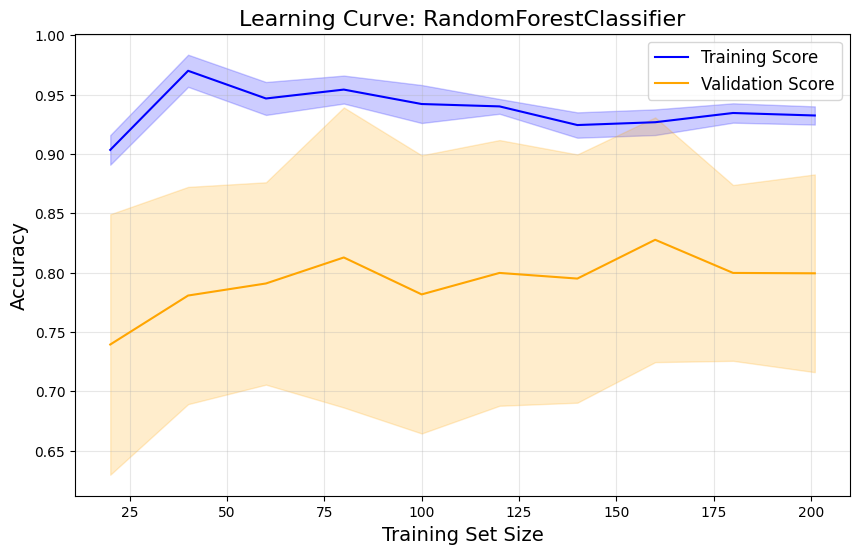

In [1469]:
# Learning Curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    estimator=rfc,
    X=X,
    y=y,
    cv=15,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),  # Vary the training size from 10% to 100%
    random_state=42
)

# Calculate mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.plot(train_sizes, val_mean, label='Validation Score', color='orange')

# Fill between mean ± std
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')

# Labels, legend, and title
plt.title('Learning Curve: RandomForestClassifier', fontsize=16)
plt.xlabel('Training Set Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

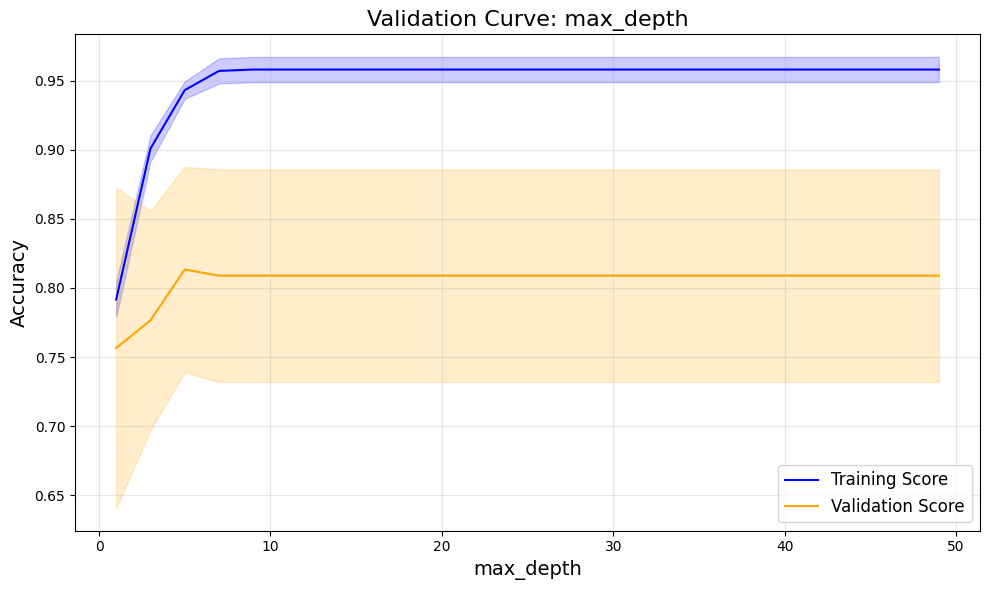

In [1470]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve

# Define the parameter and its range for the validation curve
param_name = "max_depth"
param_range = np.arange(1, 51, 2)

# Calculate training and validation scores
train_scores, val_scores = validation_curve(
    estimator=rfc,
    X=X,
    y=y,
    param_name=param_name,
    param_range=param_range,
    cv=15,  # 5-fold cross-validation
    scoring="accuracy",
    n_jobs=-1
)

# Calculate mean and standard deviation for each value of the parameter
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training Score", color="blue")
plt.plot(param_range, val_mean, label="Validation Score", color="orange")

# Add shaded areas for ± std
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, color="orange", alpha=0.2)

# Add labels and legend
plt.title(f"Validation Curve: {param_name}", fontsize=16)
plt.xlabel(param_name, fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

In [1471]:
# random search optimisation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

accuracies = []
classification_reports = []

X = filtered_path_sigs_loh.drop(columns=['Sample', 'Pathogenicity', 'Pathogenicity_Encoded'])
y = filtered_path_sigs_loh['Pathogenicity_Encoded']

X = X[important_feature_names]

# Perform KFold Cross-Validation
fold = 1
for train_index, test_index in kf.split(X):
    print(f"\nFold {fold}")
    fold += 1

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Further split the test set into validation and test sets
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

    # Keep only the important features
    # X_train_filtered = X_train[important_feature_names]
    # X_test_filtered = X_test[important_feature_names]
    # X_val_filtered = X_val[important_feature_names]

    X_train_filtered = X_train
    X_test_filtered = X_test
    X_val_filtered = X_val
    
    rfc = RandomForestClassifier(random_state=42, 
                                 bootstrap=True, 
                                 max_depth=5, 
                                 min_samples_leaf=1, 
                                 min_samples_split=8,
                                 n_estimators=497,
                                 class_weight='balanced_subsample',
                                 max_features='sqrt'
                                )

    rfc.fit(X_train_filtered, y_train)
    
    # Predict and evaluate
    y_pred = rfc.predict(X_test_filtered)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
    
    # Store results
    accuracies.append(accuracy)
    classification_reports.append(report)
    
    # Print results for the current fold
    print(f"Accuracy: {accuracy}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

print("\nOverall Performance:")
print(f"Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")


Fold 1
Accuracy: 0.7272727272727273

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.62      1.00      0.77         5

    accuracy                           0.73        11
   macro avg       0.81      0.75      0.72        11
weighted avg       0.83      0.73      0.71        11


Fold 2
Accuracy: 0.9090909090909091

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.83      1.00      0.91         5

    accuracy                           0.91        11
   macro avg       0.92      0.92      0.91        11
weighted avg       0.92      0.91      0.91        11


Fold 3
Accuracy: 0.6363636363636364

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.33      0.33      0.33        

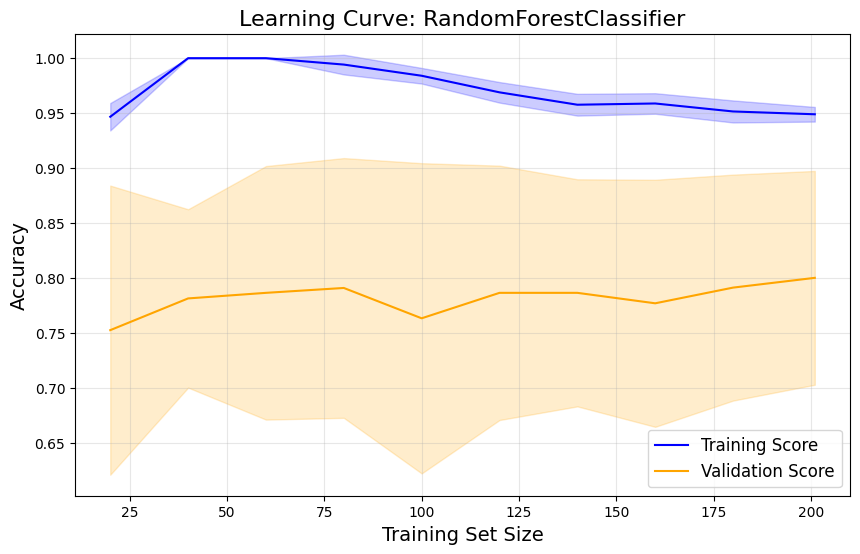

In [1472]:
# Learning Curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    estimator=rfc,
    X=X,
    y=y,
    cv=15,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),  # Vary the training size from 10% to 100%
    random_state=42
)

# Calculate mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.plot(train_sizes, val_mean, label='Validation Score', color='orange')

# Fill between mean ± std
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')

# Labels, legend, and title
plt.title('Learning Curve: RandomForestClassifier', fontsize=16)
plt.xlabel('Training Set Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

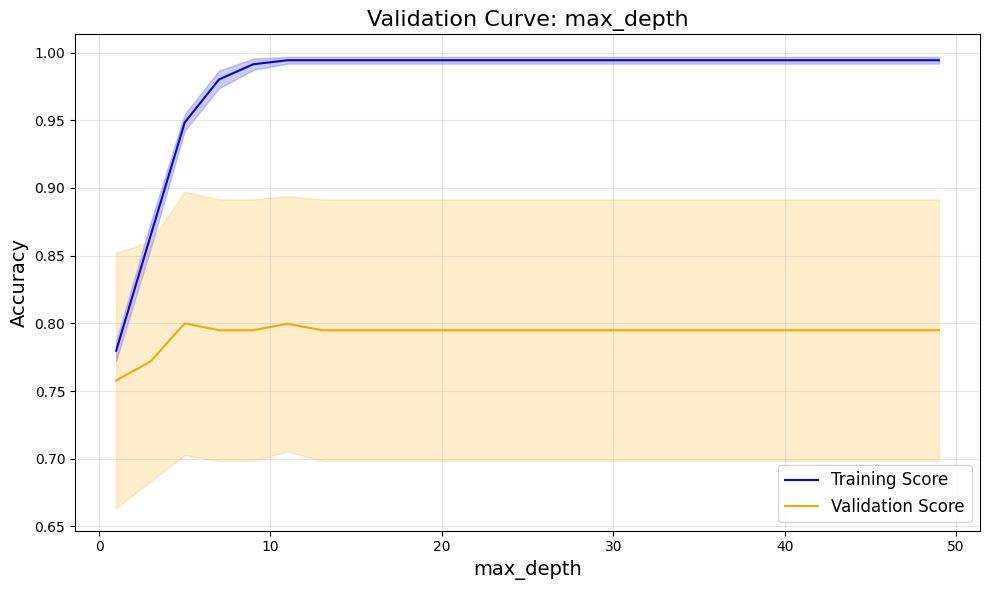

In [1473]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve

# Define the parameter and its range for the validation curve
param_name = "max_depth"
param_range = np.arange(1, 51, 2)

# Calculate training and validation scores
train_scores, val_scores = validation_curve(
    estimator=rfc,
    X=X,
    y=y,
    param_name=param_name,
    param_range=param_range,
    cv=15,  # 5-fold cross-validation
    scoring="accuracy",
    n_jobs=-1
)

# Calculate mean and standard deviation for each value of the parameter
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training Score", color="blue")
plt.plot(param_range, val_mean, label="Validation Score", color="orange")

# Add shaded areas for ± std
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, color="orange", alpha=0.2)

# Add labels and legend
plt.title(f"Validation Curve: {param_name}", fontsize=16)
plt.xlabel(param_name, fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

Looks like we are overfitting our models, since for most optimisations our training score is almost always 1 for all values.
- Need to fix this
- I'm not sure what the validation curve tells us - but very big difference between training and validation
- Figure out what all the graphs mean
- Why do some models have the training score always at 1 (panc random) while the rest are all fluctuating around 1 or increase to 0.95 and plateau?

I tried with Gradient Boosting and the results are a lot worse so will not continue with that, stick with random forest.

- Removing signatures from df doesn't change much (reducesa accuracy but not significantly)
- Plan should beto include more features instead of adding more optimisations (I think we have done enough optimisation should just add more features) - or maybe get proper mutational signatures contribution (SBS, DBS and INDEL)???

Also for the global model both random and grid optimisations are definietly overfitting the data so thats very weird. Like at least for pancreatic cancer grid search we are at least seing less gap between the learning curves.

Also we use 10 kfolds for the global and only 5 for the pancreatic cancer (idk if thats ok, i just thought with diffeernet sample sizes it would work nicer)

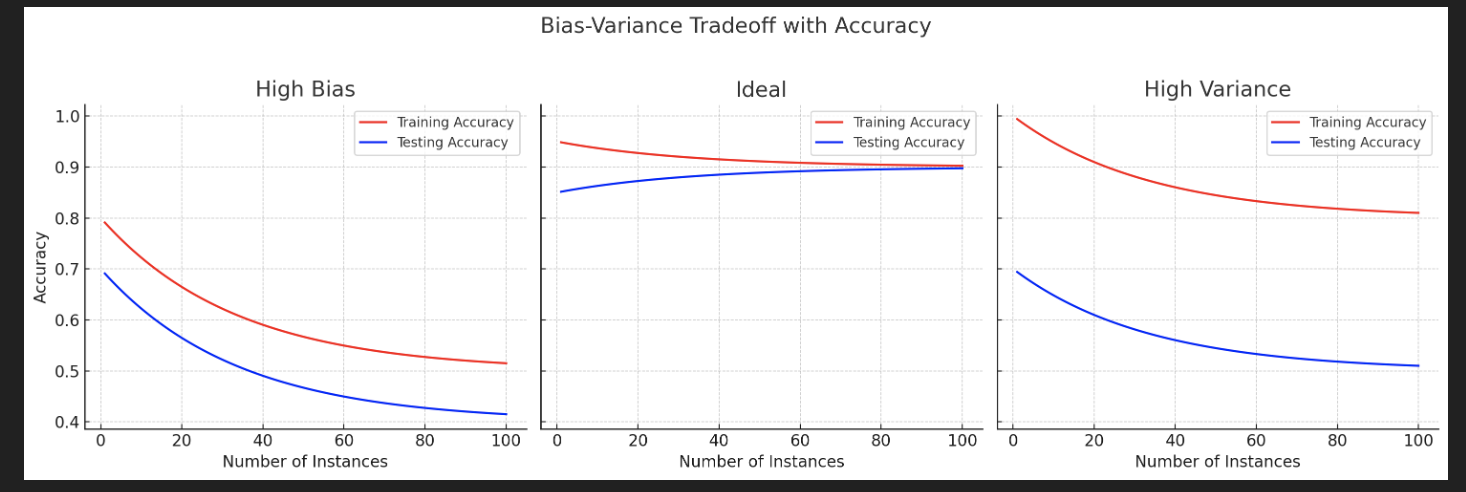

In [392]:
# Bayesian Optimisation

In [1465]:
from skopt import BayesSearchCV

X = filtered_path_sigs_loh.drop(columns=['Sample', 'Pathogenicity', 'Pathogenicity_Encoded'])
y = filtered_path_sigs_loh['Pathogenicity_Encoded']

X = X[important_feature_names]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [1466]:
# Defining the parameter space for Bayesian Optimisation
param_space = {
    'bootstrap': [True, False],
    'n_estimators': (10, 300), 
    'max_depth': (1, 20),
    'min_samples_split': (2, 20),           
    'min_samples_leaf': (1, 30),            
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_features': ['sqrt', 'log2', None]
}

# Creating a RandomForestClassifier instance
rfc = RandomForestClassifier(random_state=42, class_weight='balanced')

# Performing Bayesian Optimization
bayes_search = BayesSearchCV(
    estimator=rfc,
    search_spaces=param_space,
    n_iter=30,  # Number of parameter settings to sample
    cv=15,       # Number of cross-validation folds
    random_state=42,
    scoring='accuracy',
    n_jobs=-1
)

# Fitting the model
bayes_search.fit(X_train, y_train)

# Printing the best parameters and score
print("Best parameters:", bayes_search.best_params_)
print("Best cross-validated accuracy:", bayes_search.best_score_)

# Evaluating the model on the test set
best_rfc = bayes_search.best_estimator_
y_pred = best_rfc.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Best parameters: OrderedDict({'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 12})
Best cross-validated accuracy: 0.8224242424242425
Test Accuracy: 0.5625

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.65      0.65        20
           1       0.42      0.42      0.42        12

    accuracy                           0.56        32
   macro avg       0.53      0.53      0.53        32
weighted avg       0.56      0.56      0.56        32



In [1467]:
# bayesian search optimisation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

accuracies = []
classification_reports = []

X = filtered_path_sigs_loh.drop(columns=['Sample', 'Pathogenicity', 'Pathogenicity_Encoded'])
y = filtered_path_sigs_loh['Pathogenicity_Encoded']

X = X[important_feature_names]

# Perform KFold Cross-Validation
fold = 1
for train_index, test_index in kf.split(X):
    print(f"\nFold {fold}")
    fold += 1

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Further split the test set into validation and test sets
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

    # Keep only the important features
    # X_train_filtered = X_train[important_feature_names]
    # X_test_filtered = X_test[important_feature_names]
    # X_val_filtered = X_val[important_feature_names]

    X_train_filtered = X_train
    X_test_filtered = X_test
    X_val_filtered = X_val
    
    rfc = RandomForestClassifier(random_state=42, 
                                 bootstrap=False, 
                                 max_depth=3, 
                                 min_samples_leaf=1, 
                                 min_samples_split=2,
                                 n_estimators=12,
                                 class_weight='balanced',
                                 max_features=None
                                )
    rfc.fit(X_train_filtered, y_train)
    
    # Predict and evaluate
    y_pred = rfc.predict(X_test_filtered)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
    
    # Store results
    accuracies.append(accuracy)
    classification_reports.append(report)
    
    # Print results for the current fold
    print(f"Accuracy: {accuracy}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

print("\nOverall Performance:")
print(f"Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")


Fold 1
Accuracy: 0.6363636363636364

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.57      0.80      0.67         5

    accuracy                           0.64        11
   macro avg       0.66      0.65      0.63        11
weighted avg       0.67      0.64      0.63        11


Fold 2
Accuracy: 0.9090909090909091

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.83      1.00      0.91         5

    accuracy                           0.91        11
   macro avg       0.92      0.92      0.91        11
weighted avg       0.92      0.91      0.91        11


Fold 3
Accuracy: 0.6363636363636364

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.33      0.33      0.33        

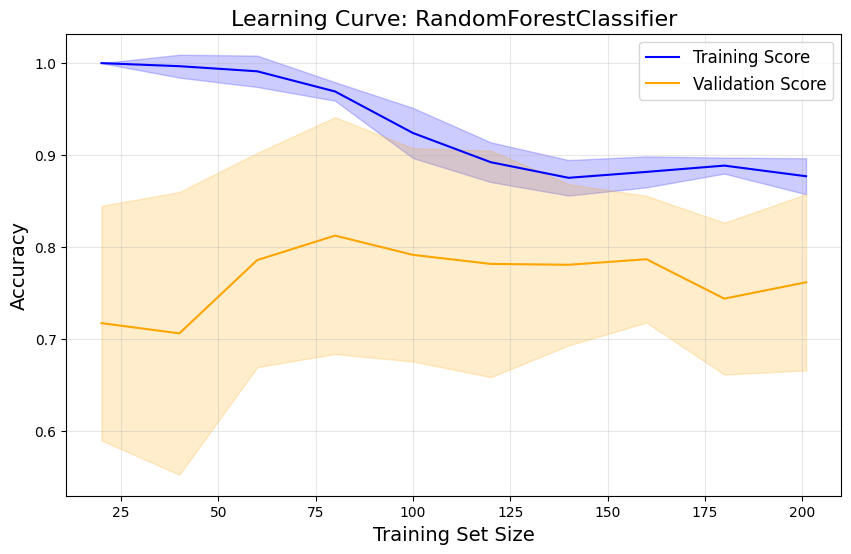

In [1357]:
# Learning Curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    estimator=rfc,
    X=X,
    y=y,
    cv=15,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),  # Vary the training size from 10% to 100%
    random_state=42
)

# Calculate mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.plot(train_sizes, val_mean, label='Validation Score', color='orange')

# Fill between mean ± std
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')

# Labels, legend, and title
plt.title('Learning Curve: RandomForestClassifier', fontsize=16)
plt.xlabel('Training Set Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

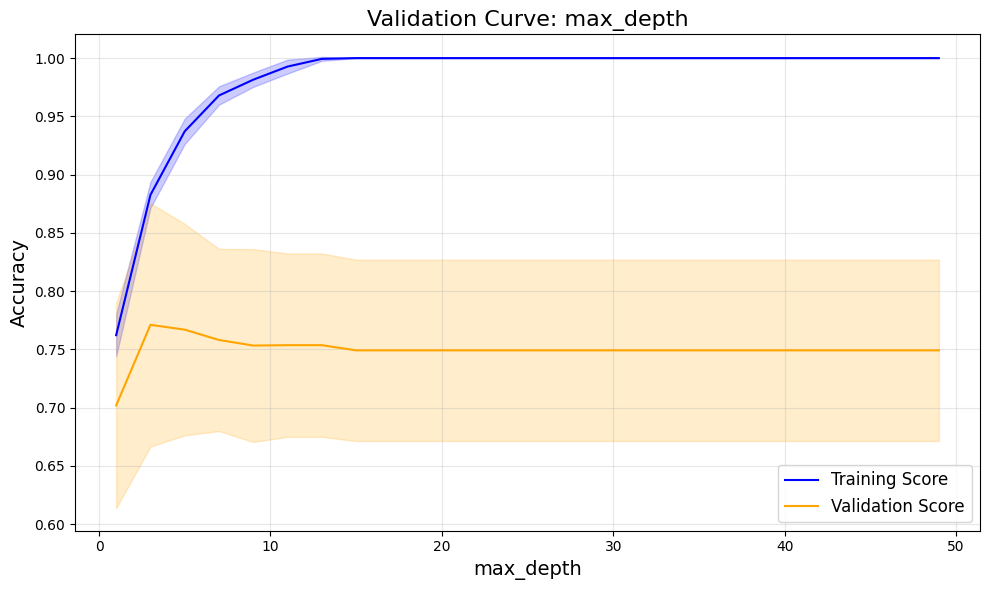

In [1358]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve

# Define the parameter and its range for the validation curve
param_name = "max_depth"
param_range = np.arange(1, 51, 2)

# Calculate training and validation scores
train_scores, val_scores = validation_curve(
    estimator=rfc,
    X=X,
    y=y,
    param_name=param_name,
    param_range=param_range,
    cv=15,  # 5-fold cross-validation
    scoring="accuracy",
    n_jobs=-1
)

# Calculate mean and standard deviation for each value of the parameter
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training Score", color="blue")
plt.plot(param_range, val_mean, label="Validation Score", color="orange")

# Add shaded areas for ± std
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, color="orange", alpha=0.2)

# Add labels and legend
plt.title(f"Validation Curve: {param_name}", fontsize=16)
plt.xlabel(param_name, fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()